In [30]:
# necessary imports
import glob
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt



In [ ]:
# -------------------------------
# 1. Data Loading, Processing, and Saving
# -------------------------------

def load_stock_data(file_pattern: str) -> pd.DataFrame:
    all_dfs = []
    files = glob.glob(file_pattern)

    for file in tqdm(files, desc="Loading JSON files"):
        try:
            with open(file, 'r') as f:
                data = json.load(f)
                metadata = data["Meta Data"]
                symbol = metadata["2. Symbol"]
                interval = metadata["4. Interval"]
                if interval != "1min":
                    print(f"Warning: {file} has interval {interval} (expected '1min'). Skipping.")
                    continue
                ts_key = f"Time Series ({interval})"
                ts_data = data.get(ts_key)
                if not ts_data:
                    print(f"Warning: {ts_key} not found in {file}. Skipping.")
                    continue
                df = pd.DataFrame(ts_data).T
                df = df.apply(pd.to_numeric)
                df["symbol"] = symbol
                all_dfs.append(df)
        except Exception as e:
            print(f"Error loading {file}: {str(e)}")
            continue

    if not all_dfs:
        raise ValueError("No valid data found in any files.")

    combined_df = pd.concat(all_dfs)
    combined_df.index = pd.to_datetime(combined_df.index)
    combined_df = combined_df.sort_index()
    combined_df.columns = [col.split(". ")[-1] for col in combined_df.columns]
    return combined_df

def process_stock_data(df: pd.DataFrame, fill_method: str = 'ffill',
                       filter_market_hours: bool = True, timezone: str = 'US/Eastern') -> pd.DataFrame:
    if df.index.tz is None:
        df.index = df.index.tz_localize(timezone)
    processed_dfs = []
    for symbol, group in df.groupby('symbol'):
        group = group[~group.index.duplicated(keep='last')]
        full_range = pd.date_range(start=group.index.min(), end=group.index.max(), freq='1T', tz=timezone)
        group = group.reindex(full_range)
        group['symbol'] = symbol
        if fill_method == 'ffill':
            group = group.ffill()
        elif fill_method == 'bfill':
            group = group.bfill()
        elif fill_method == 'interpolate':
            group = group.interpolate()
        else:
            raise ValueError(f"Invalid fill_method: {fill_method}. Use 'ffill', 'bfill', or 'interpolate'.")
        if filter_market_hours:
            group = group.between_time('09:30', '16:00')
        processed_dfs.append(group)
    processed_df = pd.concat(processed_dfs)
    return processed_df

def save_data(df: pd.DataFrame, output_path: str) -> None:
    df.to_csv(output_path, index_label='timestamp')
    print(f"Data saved to {output_path}")

def verify_data(df: pd.DataFrame) -> None:
    print("=== Data Verification ===")
    print(f"Time range: {df.index.min()} to {df.index.max()}")
    print(f"Missing values:\n{df.isnull().sum()}")
    print(f"Unique symbols: {df['symbol'].unique()}")
    print(f"Total rows: {len(df)}")

# Step 1: Load raw data
raw_df = load_stock_data("../alphavantage/data/*.json")

# Step 2: Process data
processed_df = process_stock_data(raw_df, fill_method='ffill', filter_market_hours=True)

# Step 3: Verify and (optionally) save the processed data
verify_data(processed_df)
save_data(processed_df, "processed_stock_data.csv")

# -------------------------------
# 2. Normalization
# -------------------------------

class Normalizer:
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, data):
        # data is expected to be a NumPy array (or convertible)
        if isinstance(data, pd.DataFrame):
            data = data.values
        self.mu = np.mean(data, axis=0, keepdims=True)
        self.sd = np.std(data, axis=0, keepdims=True)
        normalized_data = (data - self.mu) / self.sd
        return normalized_data

    def inverse_transform(self, normalized_data):
        return (normalized_data * self.sd) + self.mu

features_to_normalize = ['open', 'high', 'low', 'close', 'volume']
scalers = {}         # To store per-symbol scalers
normalized_dfs = []  # To collect normalized data for each symbol

for symbol, group in processed_df.groupby('symbol'):
    scaler = Normalizer()
    normalized_data = scaler.fit_transform(group[features_to_normalize])
    scalers[symbol] = scaler
    normalized_df_symbol = pd.DataFrame(normalized_data, columns=features_to_normalize, index=group.index)
    normalized_df_symbol['symbol'] = symbol
    normalized_dfs.append(normalized_df_symbol)

normalized_df = pd.concat(normalized_dfs)
print("Normalized DataFrame:")
print(normalized_df.head())

# -------------------------------
# 3. Preparing Sequences (Including Symbol Labels)
# -------------------------------

def prepare_data_x(x, window_size):
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(
        x,
        shape=(n_row, window_size),
        strides=(x.strides[0], x.strides[0])
    )
    # Use the entire sequence except for the final time step as input,
    # and reserve the final time step separately as unseen data if needed.
    return output[:-1], output[-1:]

def prepare_data_y(x, window_size):
    return x[window_size:]

WINDOW_SIZE = 60    # Number of time steps per sequence
TRAIN_SPLIT_SIZE = 0.8
EPOCHS = 50          # For demonstration; adjust as needed
BATCH_SIZE = 32

all_data_x, all_data_y, all_symbol_x = [], [], []
all_data_x_unseen, all_symbol_x_unseen = [], []

# Create a mapping from symbol string to a unique integer for embedding.
symbols = sorted(normalized_df['symbol'].unique())
symbol_to_int = {s: i for i, s in enumerate(symbols)}

for symbol, group in normalized_df.groupby('symbol'):
    # Use the normalized close price for sequence creation.
    normalized_data_close_price = group['close'].values
    data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=WINDOW_SIZE)
    data_y = prepare_data_y(normalized_data_close_price, window_size=WINDOW_SIZE)
    symbol_code = symbol_to_int[symbol]
    symbol_array = np.full((data_x.shape[0],), symbol_code, dtype=np.int32)
    symbol_array_unseen = np.array([symbol_code], dtype=np.int32)
    all_data_x.append(data_x)
    all_data_y.append(data_y)
    all_symbol_x.append(symbol_array)
    all_data_x_unseen.append(data_x_unseen)
    all_symbol_x_unseen.append(symbol_array_unseen)

data_x = np.concatenate(all_data_x, axis=0)
data_y = np.concatenate(all_data_y, axis=0)
symbol_x = np.concatenate(all_symbol_x, axis=0)
data_x_unseen = np.concatenate(all_data_x_unseen, axis=0)
symbol_x_unseen = np.concatenate(all_symbol_x_unseen, axis=0)

print(f"Input shape: {data_x.shape}")
print(f"Target shape: {data_y.shape}")
print(f"Symbol shape: {symbol_x.shape}")
print(f"Unseen data shape: {data_x_unseen.shape}")

# Split the data into training and validation sets
split_index = int(data_y.shape[0] * TRAIN_SPLIT_SIZE)
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]
symbol_x_train = symbol_x[:split_index]
symbol_x_val = symbol_x[split_index:]

# Reshape sequences to have an extra feature dimension (for close price)
data_x_train = data_x_train.reshape((data_x_train.shape[0], data_x_train.shape[1], 1))
data_x_val = data_x_val.reshape((data_x_val.shape[0], data_x_val.shape[1], 1))
data_x_unseen = data_x_unseen.reshape((data_x_unseen.shape[0], data_x_unseen.shape[1], 1))

# For embedding, symbol inputs are 2D: (samples, 1)
symbol_x_train = symbol_x_train.reshape(-1, 1)
symbol_x_val = symbol_x_val.reshape(-1, 1)
symbol_x_unseen = symbol_x_unseen.reshape(-1, 1)

print(f"Reshaped training data: {data_x_train.shape}, symbols: {symbol_x_train.shape}")
print(f"Reshaped validation data: {data_x_val.shape}, symbols: {symbol_x_val.shape}")
print(f"Reshaped unseen data: {data_x_unseen.shape}, symbols: {symbol_x_unseen.shape}")

# -------------------------------
# 4. PyTorch Multi-Input LSTM Model with Symbol Embedding
# -------------------------------

class StockDataset(Dataset):
    def __init__(self, sequences, symbols, targets):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)  # (samples, WINDOW_SIZE, 1)
        self.symbols = torch.tensor(symbols, dtype=torch.long)         # (samples, 1)
        self.targets = torch.tensor(targets, dtype=torch.float32)        # (samples,)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.sequences[idx], self.symbols[idx], self.targets[idx]

class MultiInputLSTMModelPT(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2,
                 output_size=1, dropout=0.2, num_symbols=10, embedding_dim=4):
        super(MultiInputLSTMModelPT, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # Dense layer applied to each time step
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)

        # Create LSTM layers
        self.lstm_layers = nn.ModuleList()
        for i in range(num_layers):
            self.lstm_layers.append(
                nn.LSTM(
                    input_size=hidden_layer_size,
                    hidden_size=hidden_layer_size,
                    num_layers=1,
                    batch_first=True
                )
            )
        self.dropout = nn.Dropout(dropout)
        # Embedding layer for the symbol (categorical feature)
        self.symbol_embedding = nn.Embedding(num_symbols, embedding_dim)
        # Combined dense layers
        self.combined_dense = nn.Linear(hidden_layer_size + embedding_dim, 16)
        self.relu = nn.ReLU()
        self.out_layer = nn.Linear(16, output_size)

    def forward(self, seq_input, symbol_input):
        # seq_input: (batch, seq_len, 1)
        x = self.linear_1(seq_input)  # (batch, seq_len, hidden_layer_size)

        # Process through LSTM layers sequentially
        for i, lstm in enumerate(self.lstm_layers):
            out, (h_n, c_n) = lstm(x)
            if i < len(self.lstm_layers) - 1:
                x = out  # pass full sequence to next layer
            else:
                x = h_n[-1]  # use last hidden state of the final layer

        x = self.dropout(x)

        # Process symbol input: shape (batch, 1) -> squeeze to (batch,)
        symbol_input = symbol_input.squeeze(1)
        symbol_emb = self.symbol_embedding(symbol_input)  # (batch, embedding_dim)

        # Concatenate LSTM output and symbol embedding
        combined = torch.cat([x, symbol_emb], dim=1)
        combined = self.relu(self.combined_dense(combined))
        output = self.out_layer(combined)
        return output.squeeze(1)  # (batch,)

# Define model parameters
input_size = 1
hidden_layer_size = 32
num_layers = 2
output_size = 1
dropout = 0.2
num_symbols = len(symbols)
embedding_dim = 4

model_pt = MultiInputLSTMModelPT(
    input_size=input_size,
    hidden_layer_size=hidden_layer_size,
    num_layers=num_layers,
    output_size=output_size,
    dropout=dropout,
    num_symbols=num_symbols,
    embedding_dim=embedding_dim
)

# Set up optimizer and loss
optimizer = optim.Adam(model_pt.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Create Datasets and DataLoaders
train_dataset = StockDataset(data_x_train, symbol_x_train, data_y_train)
val_dataset   = StockDataset(data_x_val, symbol_x_val, data_y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------
# 5. Training the PyTorch Model
# -------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_pt.to(device)

def run_epoch(dataloader, model, criterion, optimizer=None, is_training=False):
    epoch_loss = 0.0
    if is_training:
        model.train()
    else:
        model.eval()

    for seq_batch, symbol_batch, target_batch in dataloader:
        seq_batch = seq_batch.to(device)         # (batch, WINDOW_SIZE, 1)
        symbol_batch = symbol_batch.to(device)     # (batch, 1)
        target_batch = target_batch.to(device)     # (batch,)

        if is_training:
            optimizer.zero_grad()

        outputs = model(seq_batch, symbol_batch)
        loss = criterion(outputs, target_batch)

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += loss.item() * seq_batch.size(0)

    return epoch_loss / len(dataloader.dataset)

for epoch in range(EPOCHS):
    train_loss = run_epoch(train_loader, model_pt, criterion, optimizer, is_training=True)
    val_loss = run_epoch(val_loader, model_pt, criterion, optimizer, is_training=False)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

# Save the trained model
torch.save(model_pt.state_dict(), "trained_model_pt.pth")
print("Model saved.")

# -------------------------------
# 6. Predicting on Unseen Data (Per Stock Symbol)
# -------------------------------
#
# For each symbol, we take the most recent WINDOW_SIZE close prices (from the normalized data),
# run the model in inference mode, and then inverse transform the predicted value.
#
# NOTE: Since the Normalizer was fit on all five features and 'close' is the 4th column (index 3),
# we perform the inverse transform manually using that column’s parameters.

model_pt.eval()  # set model to evaluation mode

predictions = {}

for symbol in symbols:
    # Get normalized data for this symbol (ensure sorted by time)
    group = normalized_df[normalized_df['symbol'] == symbol].sort_index()
    
    if len(group) < WINDOW_SIZE:
        print(f"Not enough data for symbol {symbol} to create a sequence.")
        continue

    # Prepare the input sequence: last WINDOW_SIZE values of the normalized close price
    seq = group['close'].values[-WINDOW_SIZE:]
    seq = seq.reshape(1, WINDOW_SIZE, 1)
    seq_tensor = torch.tensor(seq, dtype=torch.float32).to(device)

    # Prepare the symbol input for the embedding (shape: [1, 1])
    symbol_code = np.array([[symbol_to_int[symbol]]], dtype=np.int32)
    symbol_tensor = torch.tensor(symbol_code, dtype=torch.long).to(device)

    # Make prediction
    with torch.no_grad():
        prediction_norm = model_pt(seq_tensor, symbol_tensor)  # (batch,)
    # prediction_norm is a 1D tensor of size 1; convert to NumPy and reshape to (1, 1)
    prediction_norm = prediction_norm.cpu().numpy().reshape(1, -1)
    
    # Inverse transform the normalized prediction.
    # Since the scaler was fit on [open, high, low, close, volume],
    # and 'close' is the fourth feature (index 3), we use its mean and std.
    scaler = scalers[symbol]
    pred_original = prediction_norm[0, 0] * scaler.sd[0, 3] + scaler.mu[0, 3]
    
    predictions[symbol] = pred_original
    print(f"Predicted original close price for {symbol}: {pred_original}")

# Optionally, you can now work with the `predictions` dictionary.


Loading JSON files: 100%|██████████| 120/120 [00:23<00:00,  5.05it/s]
/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/2529491859.py:48: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_range = pd.date_range(start=group.index.min(), end=group.index.max(), freq='1T', tz=timezone)


=== Data Verification ===
Time range: 2024-01-02 09:30:00-05:00 to 2024-12-31 16:00:00-05:00
Missing values:
open      0
high      0
low       0
close     0
volume    0
symbol    0
dtype: int64
Unique symbols: ['AAPL' 'AMZN' 'AVGO' 'GOOGL' 'META' 'MSFT' 'NFLX' 'NVDA' 'PYPL' 'TSLA']
Total rows: 1427150
Data saved to processed_stock_data.csv
Normalized DataFrame:
                               open      high       low     close    volume  \
2024-01-02 09:30:00-05:00 -0.803345 -0.770856 -0.831948 -0.777085  2.639778   
2024-01-02 09:31:00-05:00 -0.776965 -0.768140 -0.782270 -0.779607  0.589408   
2024-01-02 09:32:00-05:00 -0.779292 -0.755731 -0.778390 -0.758914  0.486502   
2024-01-02 09:33:00-05:00 -0.758537 -0.760770 -0.775285 -0.764282  0.317137   
2024-01-02 09:34:00-05:00 -0.764552 -0.766979 -0.780718 -0.780964  0.258956   

                          symbol  
2024-01-02 09:30:00-05:00   AAPL  
2024-01-02 09:31:00-05:00   AAPL  
2024-01-02 09:32:00-05:00   AAPL  
2024-01-02 09:33:00-0

In [22]:
# -------------------------------
# Minute-Level Pipeline
# -------------------------------

# (Assuming processed_df contains 1-minute data that has been filtered for market hours)

# Normalize each symbol’s minute data (using features: open, high, low, close, volume)
features_to_normalize = ['open', 'high', 'low', 'close', 'volume']
scalers_minute = {}
normalized_minute_dfs = []

for symbol, group in processed_df.groupby('symbol'):
    scaler = Normalizer()
    normalized_data = scaler.fit_transform(group[features_to_normalize])
    scalers_minute[symbol] = scaler
    normalized_df_symbol = pd.DataFrame(normalized_data, columns=features_to_normalize, index=group.index)
    normalized_df_symbol['symbol'] = symbol
    normalized_minute_dfs.append(normalized_df_symbol)

normalized_minute_df = pd.concat(normalized_minute_dfs).sort_index()

# Prepare sequences using a 60-minute window.
WINDOW_SIZE_MIN = 60

def prepare_data_x(x, window_size):
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(
        x,
        shape=(n_row, window_size),
        strides=(x.strides[0], x.strides[0])
    )
    return output[:-1], output[-1:]

def prepare_data_y(x, window_size):
    return x[window_size:]

all_data_x, all_data_y, all_symbol_x = [], [], []
all_data_x_unseen, all_symbol_x_unseen = [], []

# Create a mapping for embedding
symbols_minute = sorted(normalized_minute_df['symbol'].unique())
symbol_to_int_min = {s: i for i, s in enumerate(symbols_minute)}

for symbol, group in normalized_minute_df.groupby('symbol'):
    close_values = group['close'].values
    if len(close_values) < WINDOW_SIZE_MIN + 1:
        continue
    data_x, data_x_unseen = prepare_data_x(close_values, window_size=WINDOW_SIZE_MIN)
    data_y = prepare_data_y(close_values, window_size=WINDOW_SIZE_MIN)
    symbol_array = np.full((data_x.shape[0],), symbol_to_int_min[symbol], dtype=np.int32)
    symbol_array_unseen = np.array([symbol_to_int_min[symbol]], dtype=np.int32)
    all_data_x.append(data_x)
    all_data_y.append(data_y)
    all_symbol_x.append(symbol_array)
    all_data_x_unseen.append(data_x_unseen)
    all_symbol_x_unseen.append(symbol_array_unseen)

data_x_min = np.concatenate(all_data_x, axis=0)
data_y_min = np.concatenate(all_data_y, axis=0)
symbol_x_min = np.concatenate(all_symbol_x, axis=0)
data_x_unseen_min = np.concatenate(all_data_x_unseen, axis=0)
symbol_x_unseen_min = np.concatenate(all_symbol_x_unseen, axis=0)

# Reshape for model input
data_x_min = data_x_min.reshape((data_x_min.shape[0], data_x_min.shape[1], 1))
data_x_unseen_min = data_x_unseen_min.reshape((data_x_unseen_min.shape[0], data_x_unseen_min.shape[1], 1))
symbol_x_min = symbol_x_min.reshape(-1, 1)
symbol_x_unseen_min = symbol_x_unseen_min.reshape(-1, 1)

# (Now create datasets, DataLoaders, train your model, and perform predictions as in your original code.)
# ...
# For prediction (minute-level), for each symbol:
model_pt.eval()
predictions_minute = {}
for symbol in symbols_minute:
    group = normalized_minute_df[normalized_minute_df['symbol'] == symbol].sort_index()
    if len(group) < WINDOW_SIZE_MIN:
        continue
    seq = group['close'].values[-WINDOW_SIZE_MIN:]
    seq = seq.reshape(1, WINDOW_SIZE_MIN, 1)
    seq_tensor = torch.tensor(seq, dtype=torch.float32).to(device)
    symbol_code = np.array([[symbol_to_int_min[symbol]]], dtype=np.int32)
    symbol_tensor = torch.tensor(symbol_code, dtype=torch.long).to(device)
    with torch.no_grad():
        pred_norm = model_pt(seq_tensor, symbol_tensor)
    pred_norm = pred_norm.cpu().numpy().reshape(1, -1)
    # Inverse-transform the predicted close (column index 3 corresponds to 'close')
    scaler = scalers_minute[symbol]
    pred_original = pred_norm[0, 0] * scaler.sd[0, 3] + scaler.mu[0, 3]
    predictions_minute[symbol] = pred_original
    print(f"Minute-level prediction for {symbol}: {pred_original}")


Minute-level prediction for AAPL: 248.76748675783185
Minute-level prediction for AMZN: 217.5128179337743
Minute-level prediction for AVGO: 226.44207832261128
Minute-level prediction for GOOGL: 188.25396017879748
Minute-level prediction for META: 584.079837982902
Minute-level prediction for MSFT: 420.2222676228868
Minute-level prediction for NFLX: 880.409631140179
Minute-level prediction for NVDA: 136.0363999981578
Minute-level prediction for PYPL: 91.32211495761624
Minute-level prediction for TSLA: 373.92676546677717


In [23]:
# -------------------------------
# Hour-Level Pipeline
# -------------------------------

# Function to aggregate intraday (1-minute) data to hourly data per day.
def aggregate_intraday_hourly(df):
    df = df.copy()
    df['date'] = df.index.date
    hourly_dfs = []
    for date, group in df.groupby('date'):
        group_hourly = group.resample('60T').agg({
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
            'volume': 'sum'
        })
        group_hourly['symbol'] = group['symbol'].iloc[0]
        hourly_dfs.append(group_hourly)
    hourly_df = pd.concat(hourly_dfs)
    hourly_df.index = pd.to_datetime(hourly_df.index)
    hourly_df = hourly_df.sort_index()
    return hourly_df

# Aggregate for all symbols:
hourly_dfs_all = []
for symbol, group in processed_df.groupby('symbol'):
    hourly_df = aggregate_intraday_hourly(group)
    hourly_dfs_all.append(hourly_df)
hourly_df = pd.concat(hourly_dfs_all).sort_index()

# Normalize hourly data.
features_to_normalize = ['open', 'high', 'low', 'close', 'volume']
scalers_hourly = {}
normalized_hourly_dfs = []

for symbol, group in hourly_df.groupby('symbol'):
    scaler = Normalizer()
    normalized_data = scaler.fit_transform(group[features_to_normalize])
    scalers_hourly[symbol] = scaler
    norm_df = pd.DataFrame(normalized_data, columns=features_to_normalize, index=group.index)
    norm_df['symbol'] = symbol
    normalized_hourly_dfs.append(norm_df)
    
normalized_hourly_df = pd.concat(normalized_hourly_dfs).sort_index()

# Prepare sequences. For example, using a window of 6 hourly intervals.
WINDOW_SIZE_HOUR = 6

def prepare_data_x(x, window_size):
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(
        x,
        shape=(n_row, window_size),
        strides=(x.strides[0], x.strides[0])
    )
    return output[:-1], output[-1:]

def prepare_data_y(x, window_size):
    return x[window_size:]

all_data_x_hour, all_data_y_hour, all_symbol_x_hour = [], [], []
all_data_x_unseen_hour, all_symbol_x_unseen_hour = [], []

symbols_hourly = sorted(normalized_hourly_df['symbol'].unique())
symbol_to_int_hour = {s: i for i, s in enumerate(symbols_hourly)}

for symbol, group in normalized_hourly_df.groupby('symbol'):
    close_values = group['close'].values
    if len(close_values) < WINDOW_SIZE_HOUR + 1:
        continue
    data_x, data_x_unseen = prepare_data_x(close_values, window_size=WINDOW_SIZE_HOUR)
    data_y = prepare_data_y(close_values, window_size=WINDOW_SIZE_HOUR)
    symbol_array = np.full((data_x.shape[0],), symbol_to_int_hour[symbol], dtype=np.int32)
    symbol_array_unseen = np.array([symbol_to_int_hour[symbol]], dtype=np.int32)
    all_data_x_hour.append(data_x)
    all_data_y_hour.append(data_y)
    all_symbol_x_hour.append(symbol_array)
    all_data_x_unseen_hour.append(data_x_unseen)
    all_symbol_x_unseen_hour.append(symbol_array_unseen)

data_x_hour = np.concatenate(all_data_x_hour, axis=0)
data_y_hour = np.concatenate(all_data_y_hour, axis=0)
symbol_x_hour = np.concatenate(all_symbol_x_hour, axis=0)
data_x_unseen_hour = np.concatenate(all_data_x_unseen_hour, axis=0)
symbol_x_unseen_hour = np.concatenate(all_symbol_x_unseen_hour, axis=0)

# Reshape for model input.
data_x_hour = data_x_hour.reshape((data_x_hour.shape[0], data_x_hour.shape[1], 1))
data_x_unseen_hour = data_x_unseen_hour.reshape((data_x_unseen_hour.shape[0], data_x_unseen_hour.shape[1], 1))
symbol_x_hour = symbol_x_hour.reshape(-1, 1)
symbol_x_unseen_hour = symbol_x_unseen_hour.reshape(-1, 1)

# (Then split into training/validation, create datasets/DataLoaders, train your model, etc.)
# ...
# For prediction (hour-level), for each symbol:
model_pt.eval()
predictions_hourly = {}
for symbol in symbols_hourly:
    group = normalized_hourly_df[normalized_hourly_df['symbol'] == symbol].sort_index()
    if len(group) < WINDOW_SIZE_HOUR:
        continue
    seq = group['close'].values[-WINDOW_SIZE_HOUR:]
    seq = seq.reshape(1, WINDOW_SIZE_HOUR, 1)
    seq_tensor = torch.tensor(seq, dtype=torch.float32).to(device)
    symbol_code = np.array([[symbol_to_int_hour[symbol]]], dtype=np.int32)
    symbol_tensor = torch.tensor(symbol_code, dtype=torch.long).to(device)
    with torch.no_grad():
        pred_norm = model_pt(seq_tensor, symbol_tensor)
    pred_norm = pred_norm.cpu().numpy().reshape(1, -1)
    scaler = scalers_hourly[symbol]
    pred_original = pred_norm[0, 0] * scaler.sd[0, 3] + scaler.mu[0, 3]
    predictions_hourly[symbol] = pred_original
    print(f"Hour-level prediction for {symbol}: {pred_original}")


/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/3157055311.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  group_hourly = group.resample('60T').agg({
/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/3157055311.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  group_hourly = group.resample('60T').agg({
/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/3157055311.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  group_hourly = group.resample('60T').agg({
/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/3157055311.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  group_hourly = group.resample('60T').agg({
/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/3157055311.py:11: Futur

Hour-level prediction for AAPL: 248.78590371023336
Hour-level prediction for AMZN: 217.49314339585894
Hour-level prediction for AVGO: 226.27544237366297
Hour-level prediction for GOOGL: 188.2942355502875
Hour-level prediction for META: 584.3024568646622
Hour-level prediction for MSFT: 420.4007466000544
Hour-level prediction for NFLX: 880.3991631126902
Hour-level prediction for NVDA: 136.3089430368742
Hour-level prediction for PYPL: 91.33483100248507
Hour-level prediction for TSLA: 373.1458900709862


/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/3157055311.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  group_hourly = group.resample('60T').agg({
/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/3157055311.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  group_hourly = group.resample('60T').agg({
/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/3157055311.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  group_hourly = group.resample('60T').agg({
/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/3157055311.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  group_hourly = group.resample('60T').agg({
/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/3157055311.py:11: Futur

In [24]:
# -------------------------------
# Day-Level Pipeline
# -------------------------------

# Aggregate processed data to daily OHLC. (Assume processed_df is indexed by datetime.)
daily_dfs = []
for symbol, group in processed_df.groupby('symbol'):
    group = group.sort_index()
    daily = group.resample('B').agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    })
    daily['symbol'] = symbol
    # Drop any day with missing data (e.g. partial days)
    daily = daily.dropna()
    daily_dfs.append(daily)
daily_df = pd.concat(daily_dfs).sort_index()

# Normalize daily data.
scalers_daily = {}
normalized_daily_dfs = []

for symbol, group in daily_df.groupby('symbol'):
    scaler = Normalizer()
    normalized_data = scaler.fit_transform(group[features_to_normalize])
    scalers_daily[symbol] = scaler
    norm_df = pd.DataFrame(normalized_data, columns=features_to_normalize, index=group.index)
    norm_df['symbol'] = symbol
    normalized_daily_dfs.append(norm_df)
    
normalized_daily_df = pd.concat(normalized_daily_dfs).sort_index()

# Prepare sequences using a window of, say, 10 days.
WINDOW_SIZE_DAY = 10

def prepare_data_x(x, window_size):
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(
        x,
        shape=(n_row, window_size),
        strides=(x.strides[0], x.strides[0])
    )
    return output[:-1], output[-1:]

def prepare_data_y(x, window_size):
    return x[window_size:]

all_data_x_day, all_data_y_day, all_symbol_x_day = [], [], []
all_data_x_unseen_day, all_symbol_x_unseen_day = [], []

symbols_daily = sorted(normalized_daily_df['symbol'].unique())
symbol_to_int_day = {s: i for i, s in enumerate(symbols_daily)}

for symbol, group in normalized_daily_df.groupby('symbol'):
    close_values = group['close'].values
    if len(close_values) < WINDOW_SIZE_DAY + 1:
        continue
    data_x, data_x_unseen = prepare_data_x(close_values, window_size=WINDOW_SIZE_DAY)
    data_y = prepare_data_y(close_values, window_size=WINDOW_SIZE_DAY)
    symbol_array = np.full((data_x.shape[0],), symbol_to_int_day[symbol], dtype=np.int32)
    symbol_array_unseen = np.array([symbol_to_int_day[symbol]], dtype=np.int32)
    all_data_x_day.append(data_x)
    all_data_y_day.append(data_y)
    all_symbol_x_day.append(symbol_array)
    all_data_x_unseen_day.append(data_x_unseen)
    all_symbol_x_unseen_day.append(symbol_array_unseen)

data_x_day = np.concatenate(all_data_x_day, axis=0)
data_y_day = np.concatenate(all_data_y_day, axis=0)
symbol_x_day = np.concatenate(all_symbol_x_day, axis=0)
data_x_unseen_day = np.concatenate(all_data_x_unseen_day, axis=0)
symbol_x_unseen_day = np.concatenate(all_symbol_x_unseen_day, axis=0)

# Reshape for model input.
data_x_day = data_x_day.reshape((data_x_day.shape[0], data_x_day.shape[1], 1))
data_x_unseen_day = data_x_unseen_day.reshape((data_x_unseen_day.shape[0], data_x_unseen_day.shape[1], 1))
symbol_x_day = symbol_x_day.reshape(-1, 1)
symbol_x_unseen_day = symbol_x_unseen_day.reshape(-1, 1)

# (Split into training/validation sets, create datasets/DataLoaders, and train your model.)
# ...
# For prediction (day-level), for each symbol:
model_pt.eval()
predictions_daily = {}
for symbol in symbols_daily:
    group = normalized_daily_df[normalized_daily_df['symbol'] == symbol].sort_index()
    if len(group) < WINDOW_SIZE_DAY:
        continue
    seq = group['close'].values[-WINDOW_SIZE_DAY:]
    seq = seq.reshape(1, WINDOW_SIZE_DAY, 1)
    seq_tensor = torch.tensor(seq, dtype=torch.float32).to(device)
    symbol_code = np.array([[symbol_to_int_day[symbol]]], dtype=np.int32)
    symbol_tensor = torch.tensor(symbol_code, dtype=torch.long).to(device)
    with torch.no_grad():
        pred_norm = model_pt(seq_tensor, symbol_tensor)
    pred_norm = pred_norm.cpu().numpy().reshape(1, -1)
    scaler = scalers_daily[symbol]
    pred_original = pred_norm[0, 0] * scaler.sd[0, 3] + scaler.mu[0, 3]
    predictions_daily[symbol] = pred_original
    print(f"Day-level prediction for {symbol}: {pred_original}")


Day-level prediction for AAPL: 248.37407423243457
Day-level prediction for AMZN: 217.08814277097088
Day-level prediction for AVGO: 224.7019385481617
Day-level prediction for GOOGL: 187.84730697537736
Day-level prediction for META: 582.7448379454404
Day-level prediction for MSFT: 420.83009401524055
Day-level prediction for NFLX: 877.9172477670799
Day-level prediction for NVDA: 133.9983120830445
Day-level prediction for PYPL: 91.38104135433402
Day-level prediction for TSLA: 368.08839123631765


## Minute-level Plots

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/282850254.py:9: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


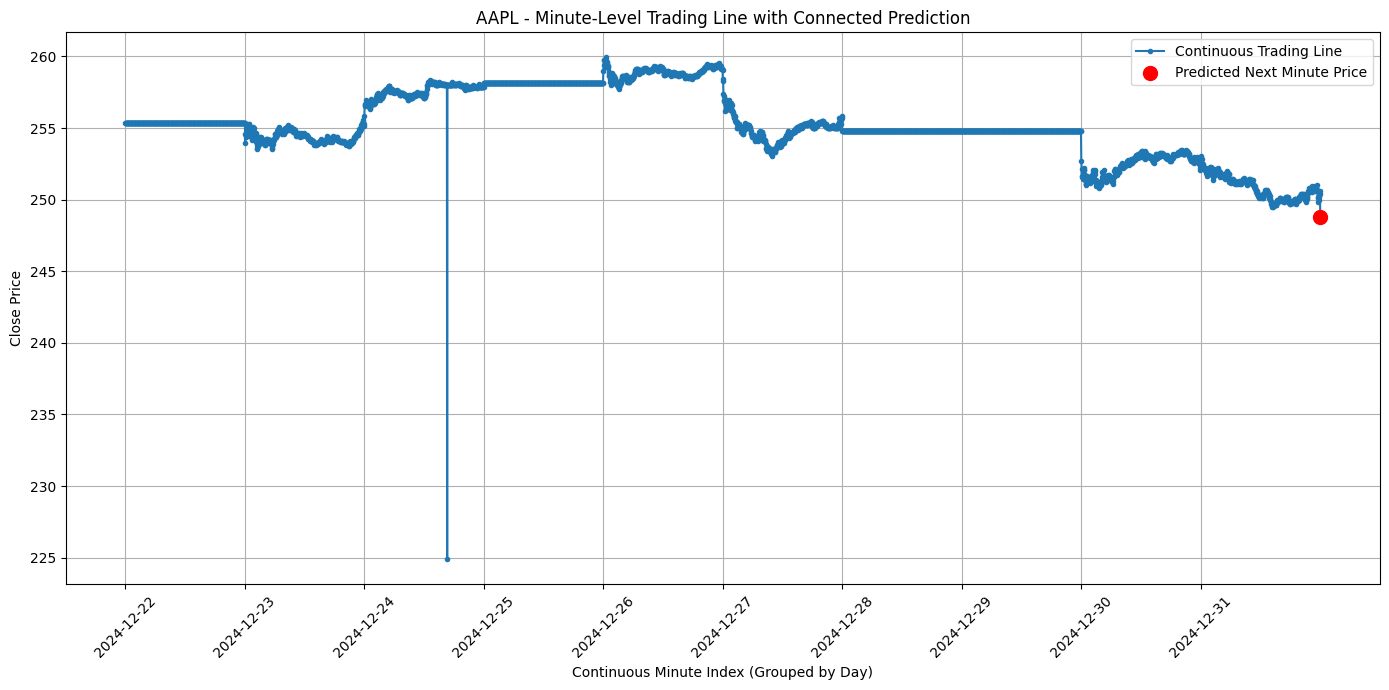

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/282850254.py:9: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


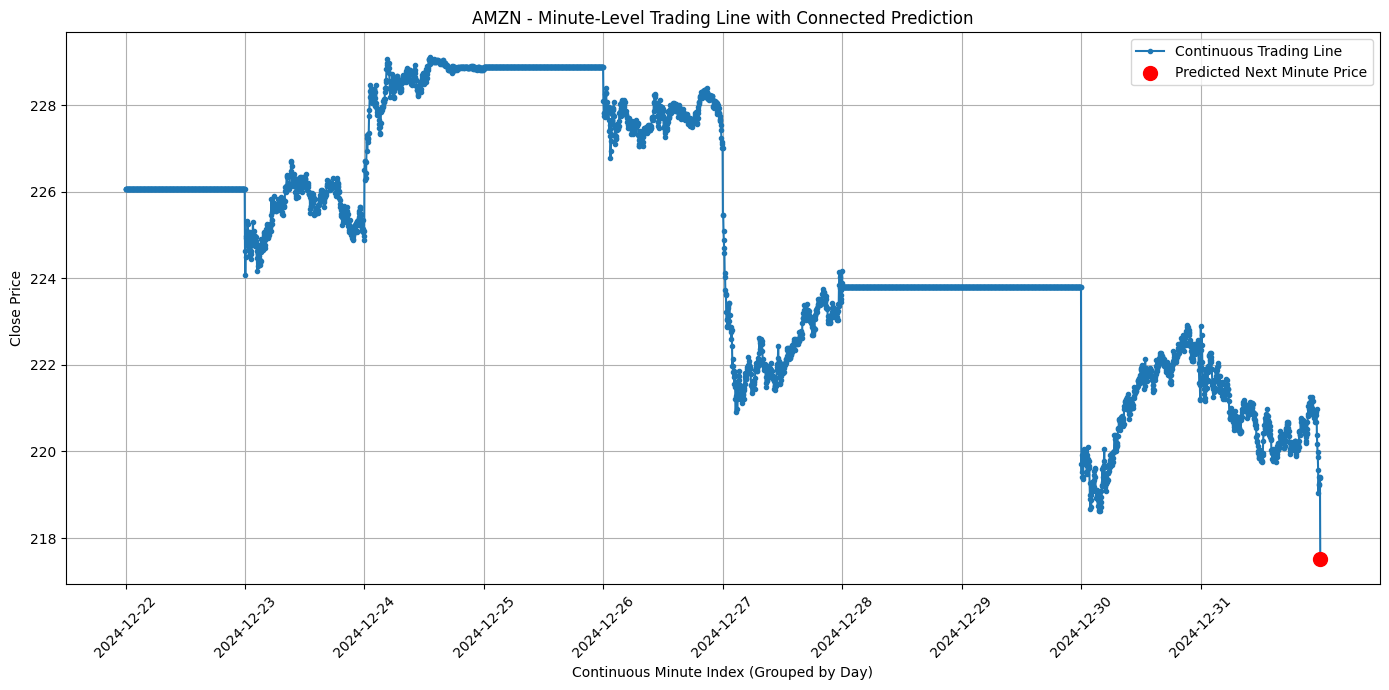

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/282850254.py:9: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


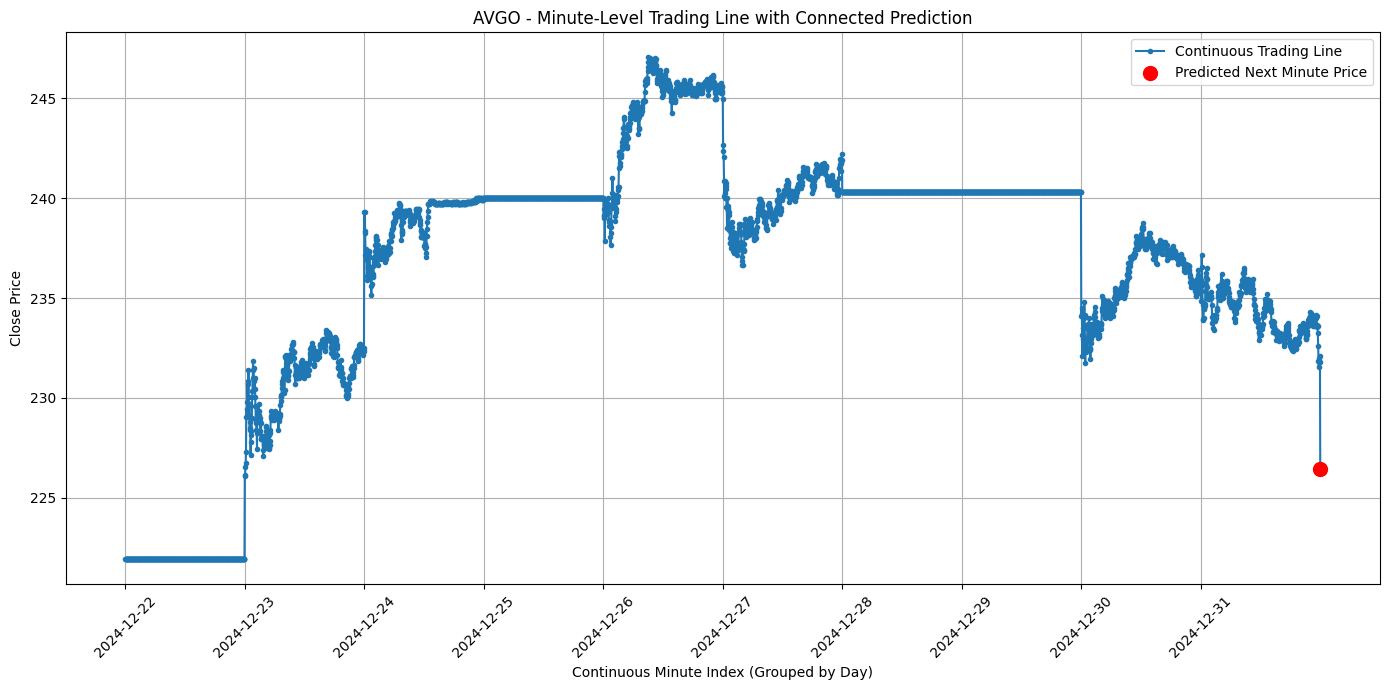

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/282850254.py:9: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


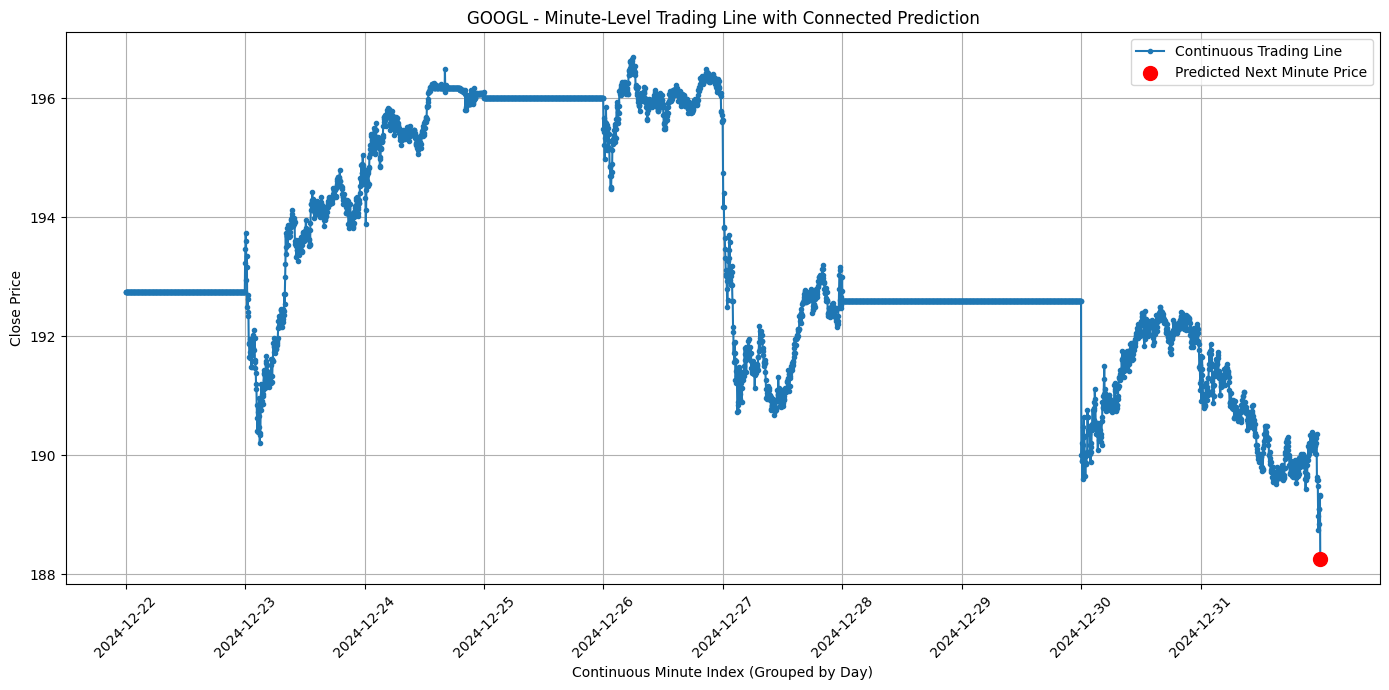

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/282850254.py:9: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


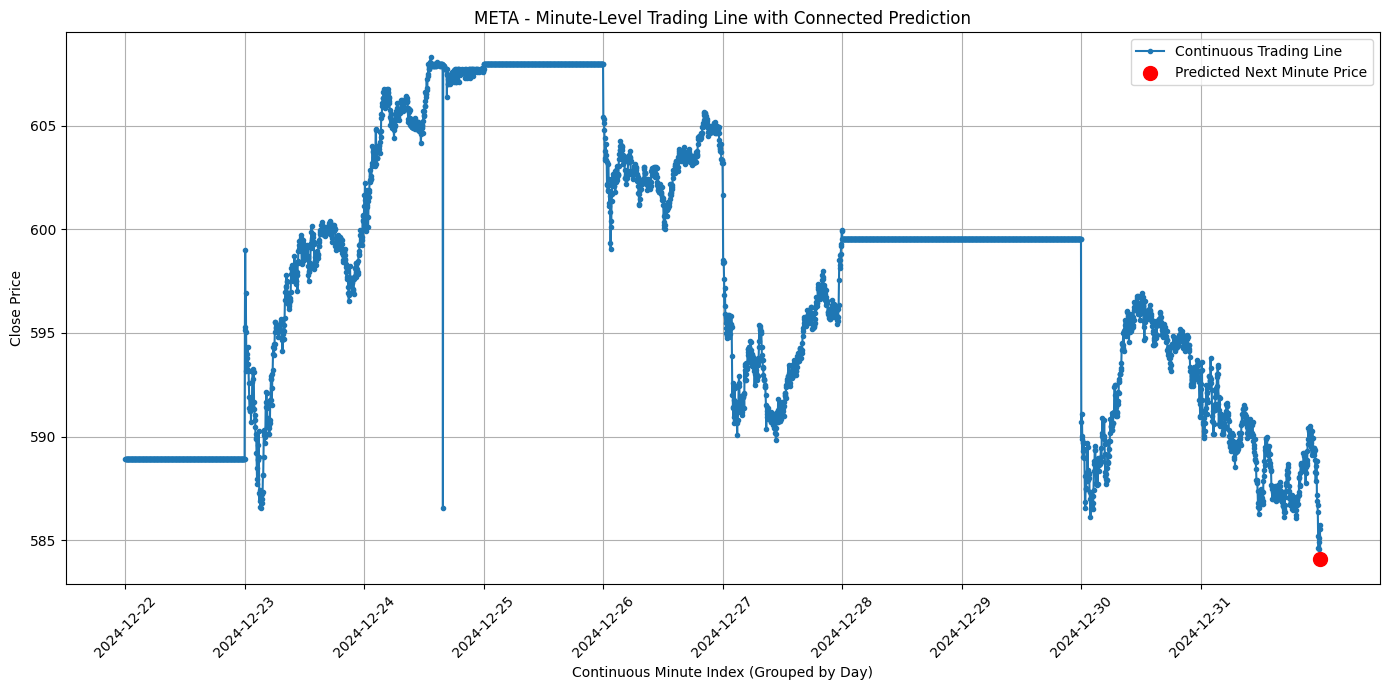

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/282850254.py:9: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


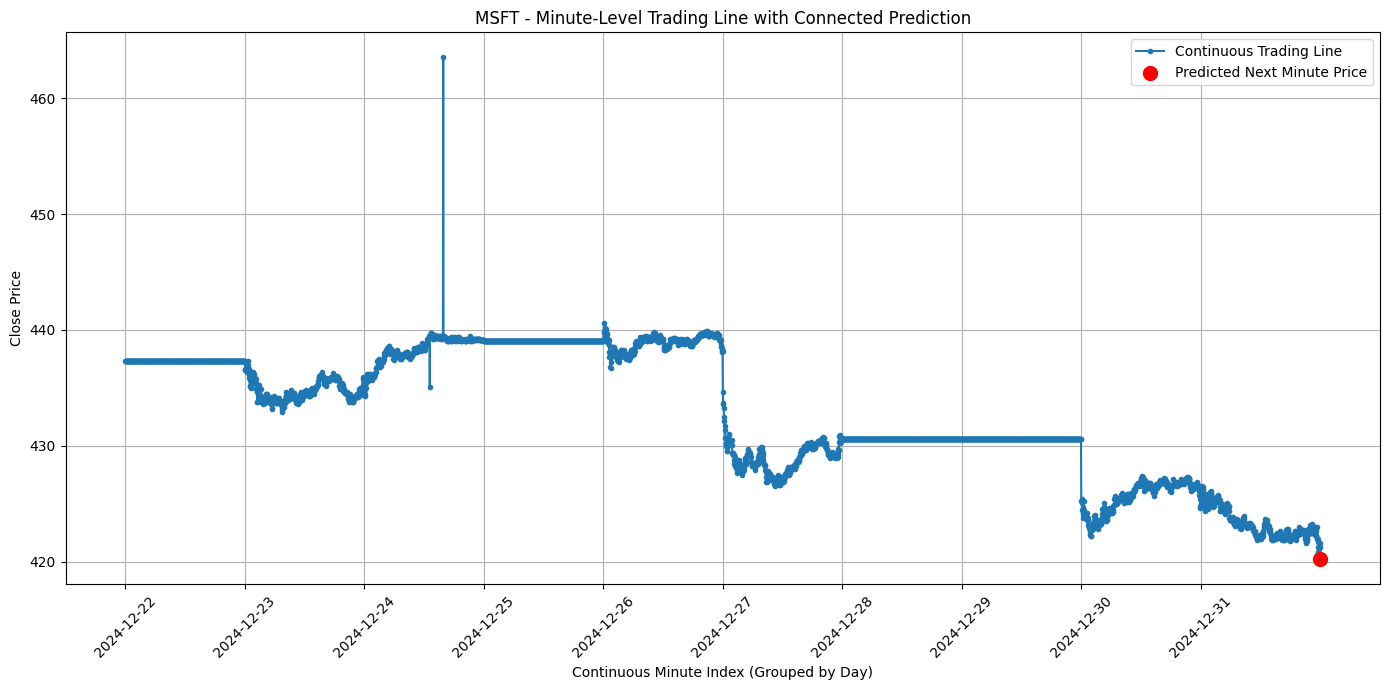

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/282850254.py:9: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


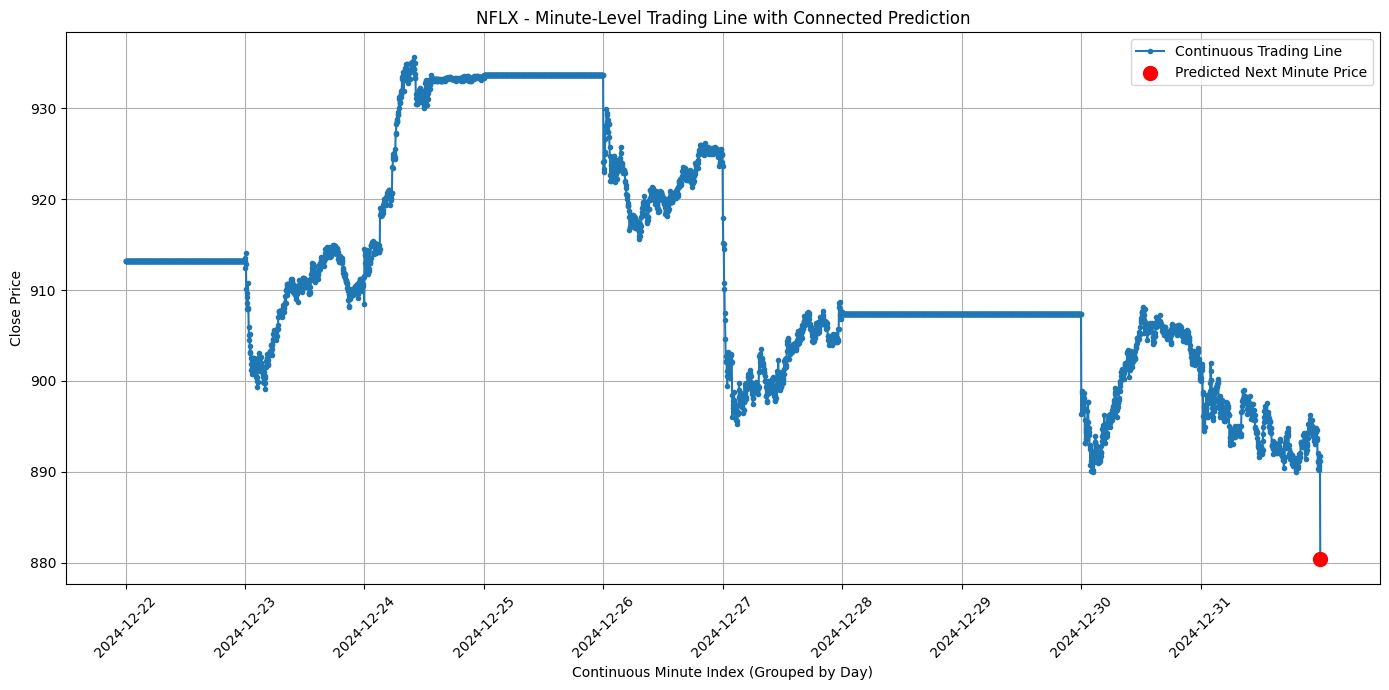

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/282850254.py:9: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


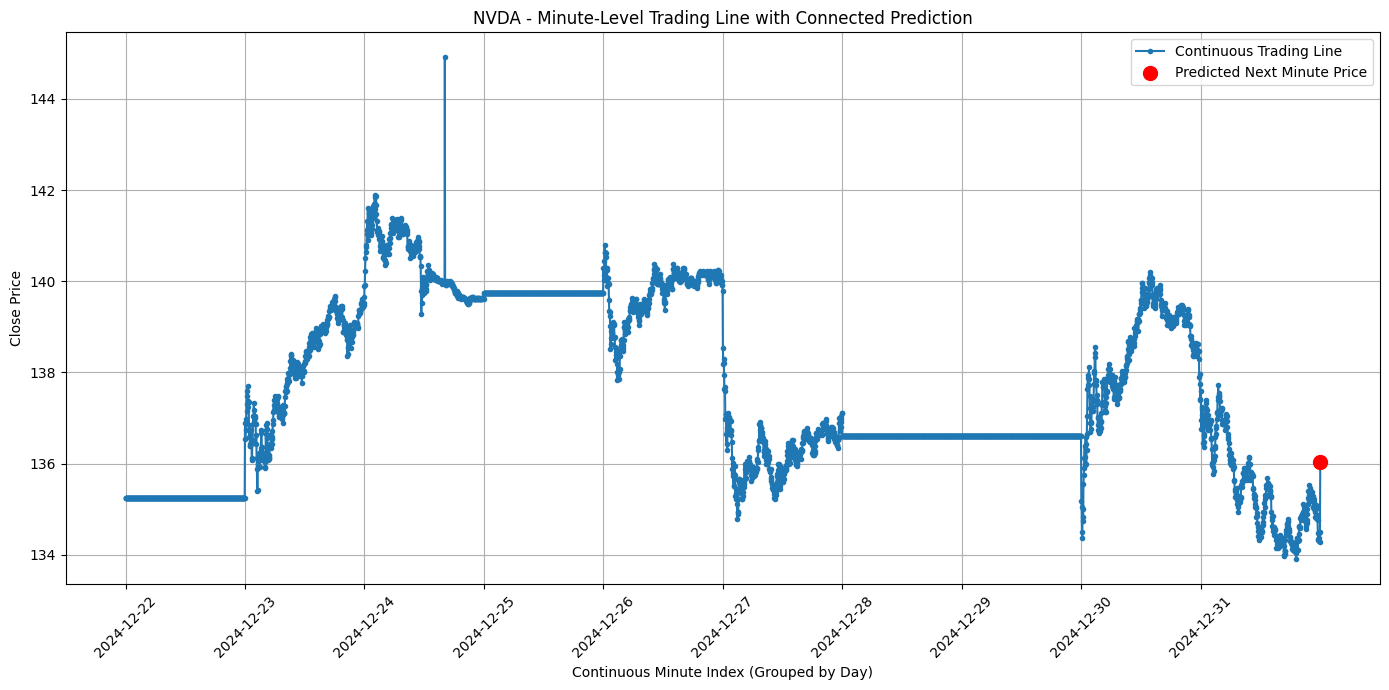

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/282850254.py:9: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


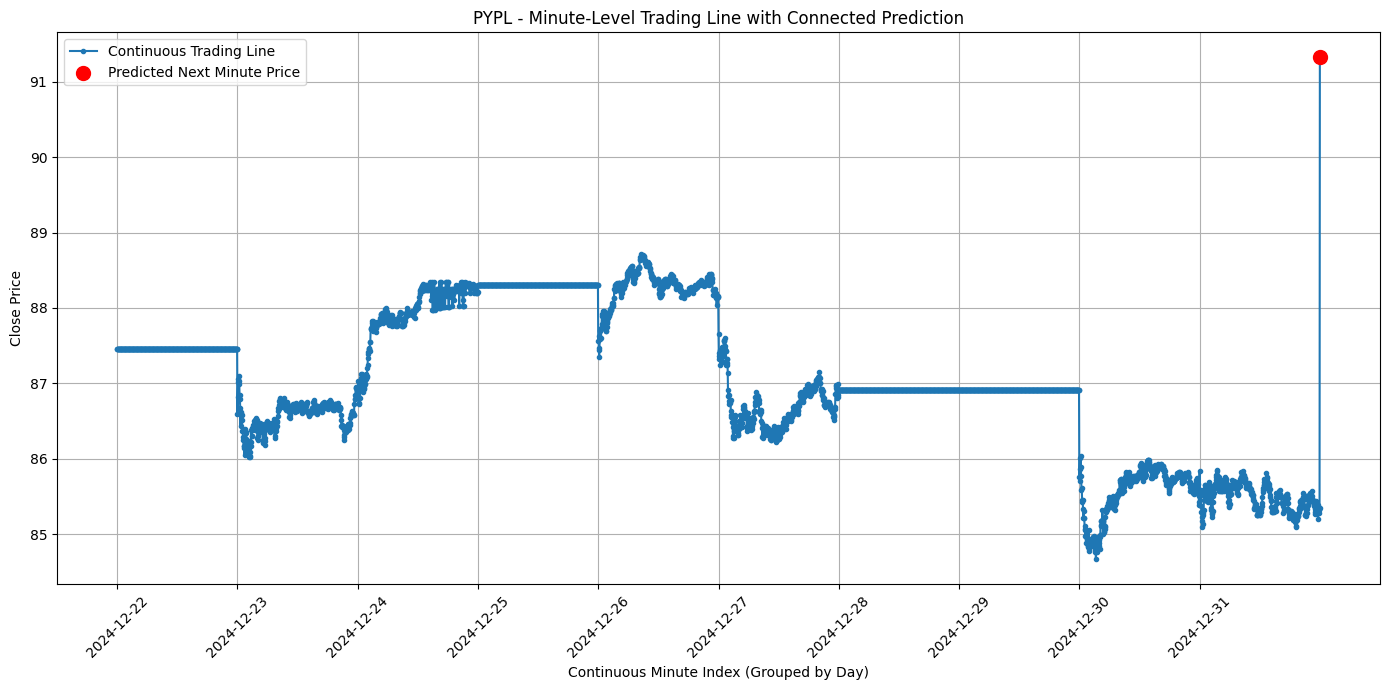

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/282850254.py:9: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


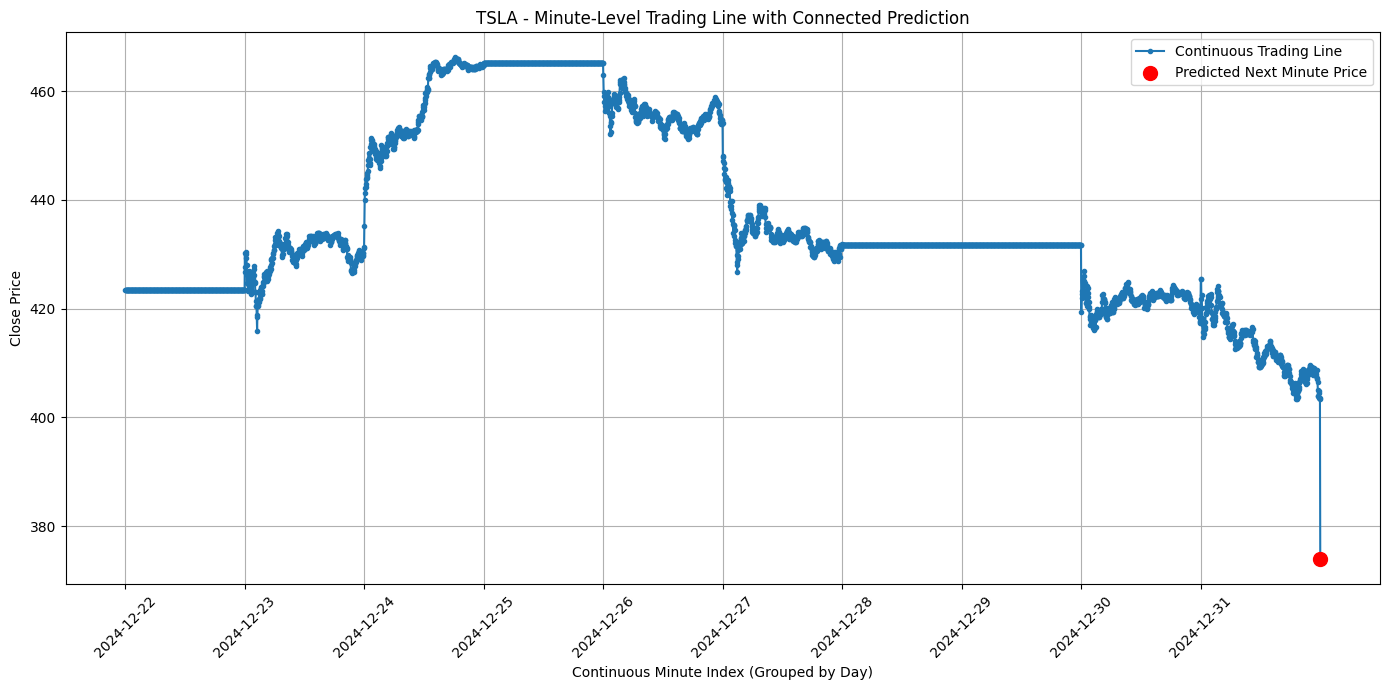

In [26]:
import matplotlib.pyplot as plt
import numpy as np

for symbol in symbols_minute:
    # Get the raw 1-minute data for this symbol and sort by time.
    df_symbol = processed_df[processed_df['symbol'] == symbol].sort_index()
    
    # Use the last 10 days of data.
    last_10_days = df_symbol.last("10D")
    
    # Reset the index to create a continuous sequence.
    df_cont = last_10_days.copy()
    df_cont['time'] = df_cont.index
    df_cont = df_cont.reset_index(drop=True)
    
    # Create a continuous x-axis.
    x = np.arange(len(df_cont))
    pred_x = len(df_cont)  # The prediction corresponds to the next minute.
    
    # Retrieve the predicted next-minute close price.
    pred_price = predictions_minute.get(symbol)
    if pred_price is None:
        print(f"Minute-level: No prediction available for {symbol}.")
        continue

    # Extend the historical data by appending the predicted point.
    x_extended = np.append(x, pred_x)
    y_extended = np.append(df_cont['close'].values, pred_price)
    
    plt.figure(figsize=(14, 7))
    plt.plot(x_extended, y_extended, label="Continuous Trading Line", marker='.', linestyle='-')
    plt.scatter([pred_x], [pred_price], color='red', s=100, zorder=5, label="Predicted Next Minute Price")
    
    # Annotate the x-axis with day labels.
    df_cont['date'] = df_cont['time'].dt.strftime('%Y-%m-%d')
    tick_positions = []
    tick_labels = []
    for date, group in df_cont.groupby('date'):
        tick_positions.append(group.index[0])
        tick_labels.append(date)
    
    plt.xticks(tick_positions, tick_labels, rotation=45)
    plt.xlabel("Continuous Minute Index (Grouped by Day)")
    plt.ylabel("Close Price")
    plt.title(f"{symbol} - Minute-Level Trading Line with Connected Prediction")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Hour-level Plots

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1249319091.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


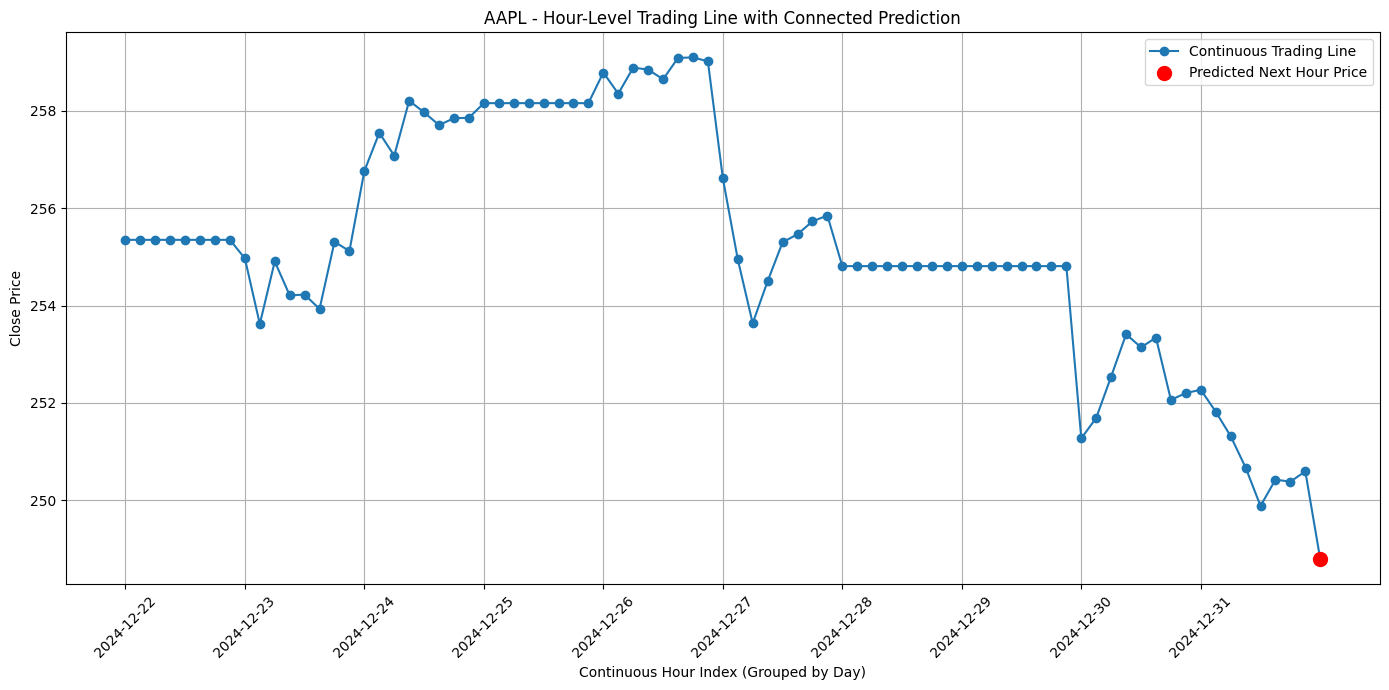

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1249319091.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


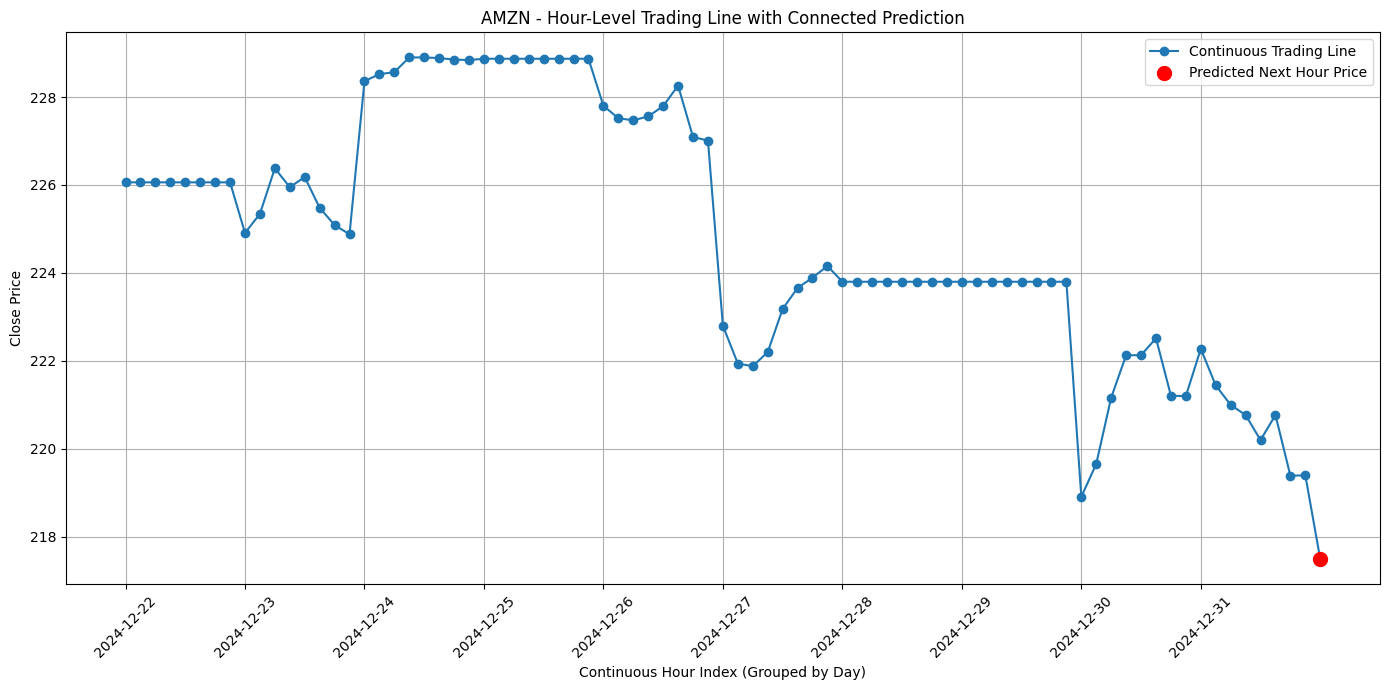

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1249319091.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


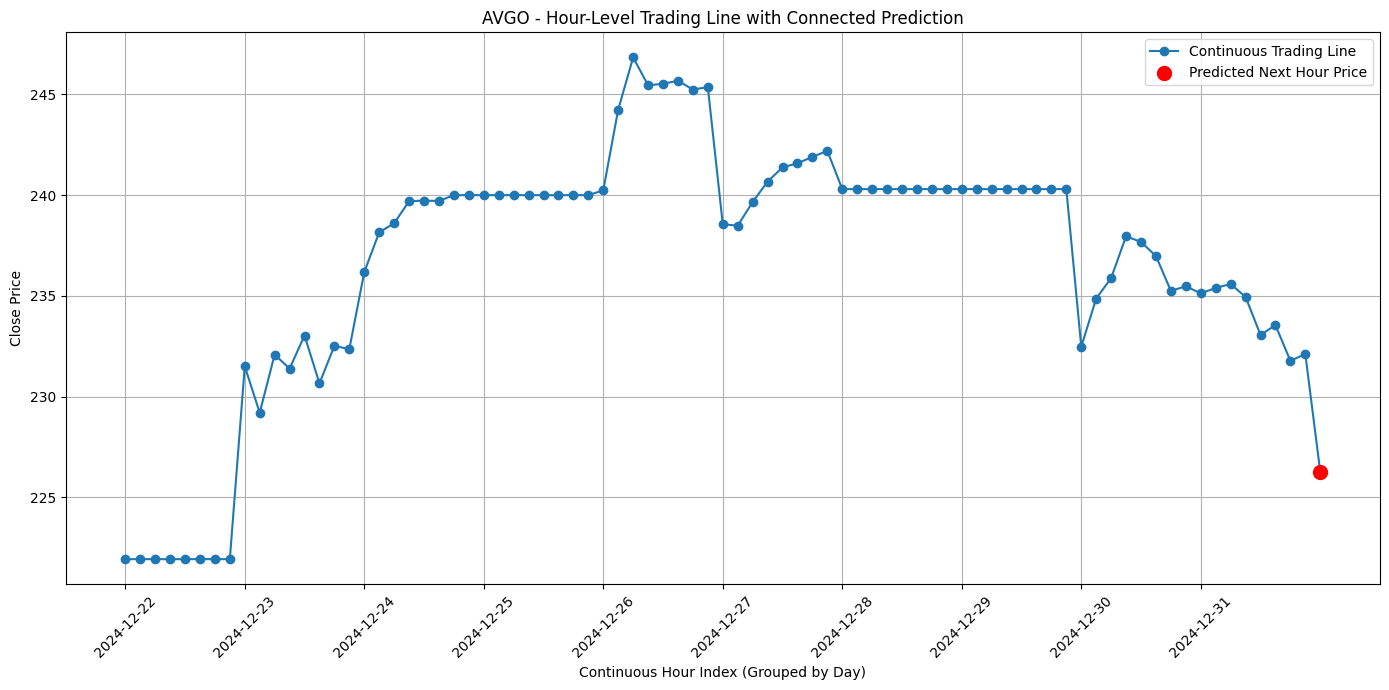

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1249319091.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


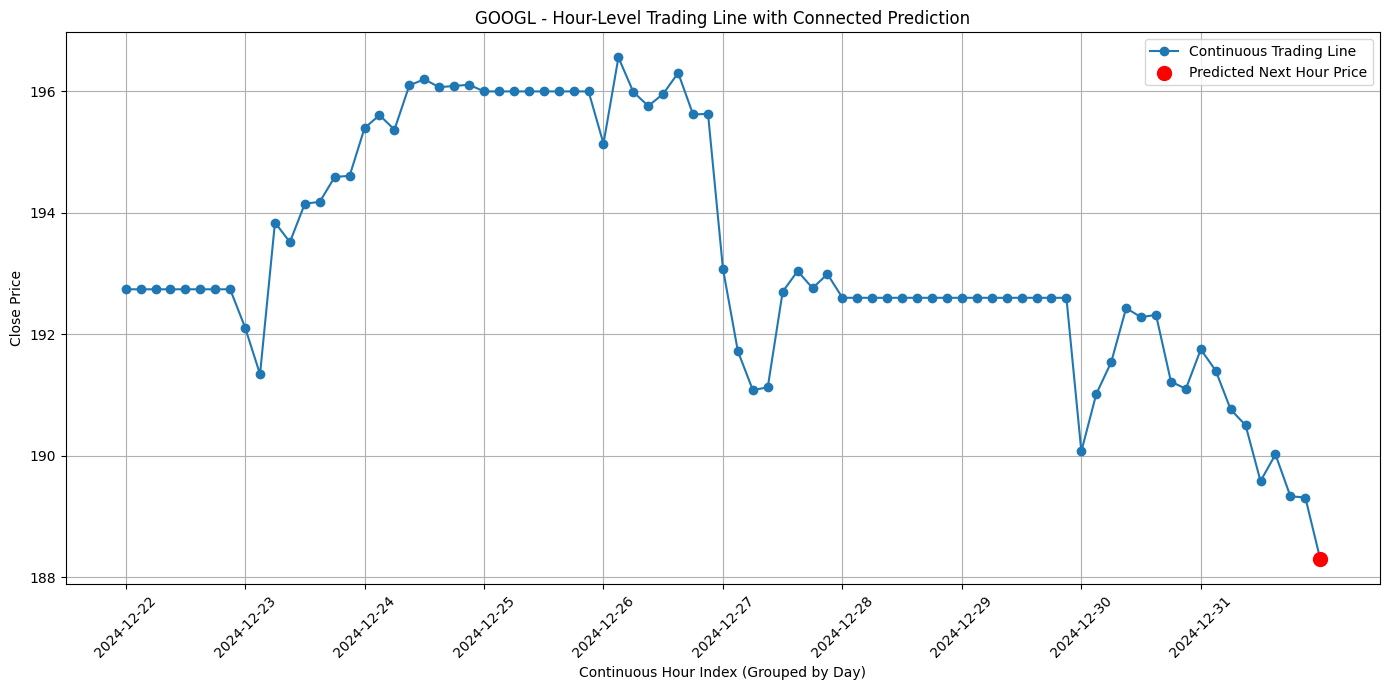

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1249319091.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


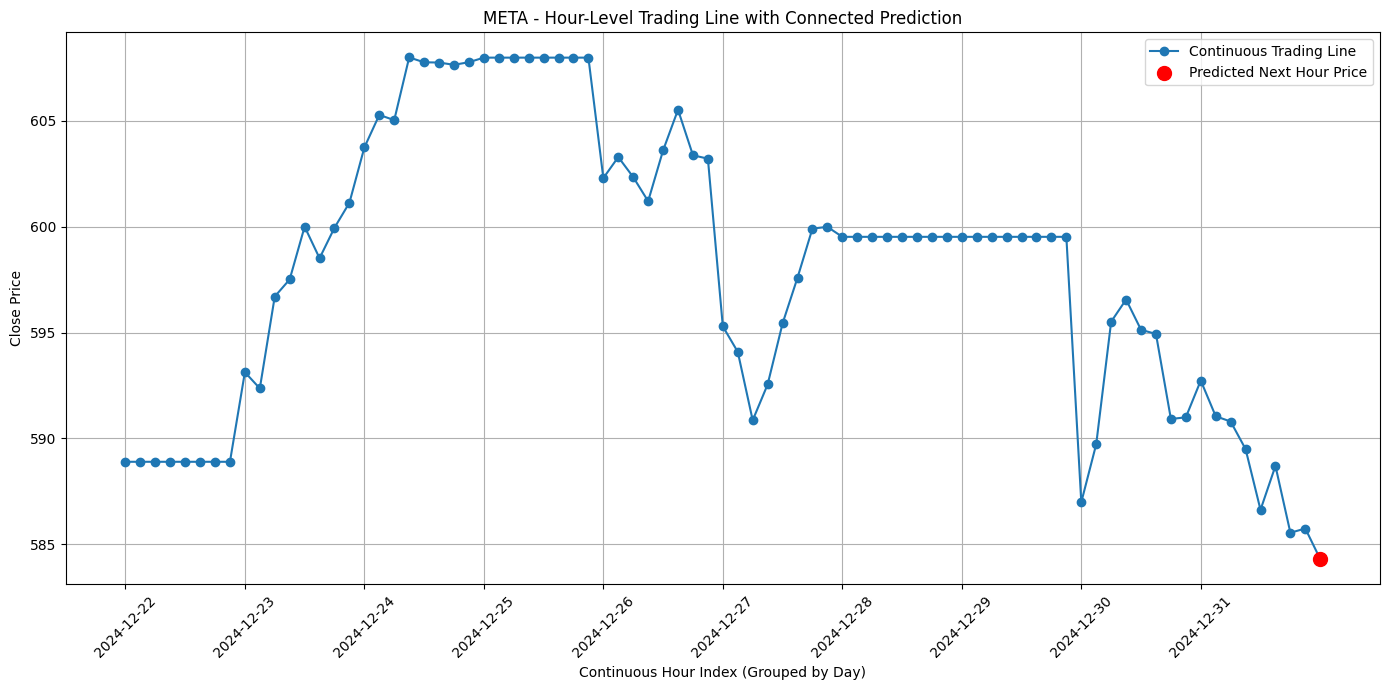

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1249319091.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


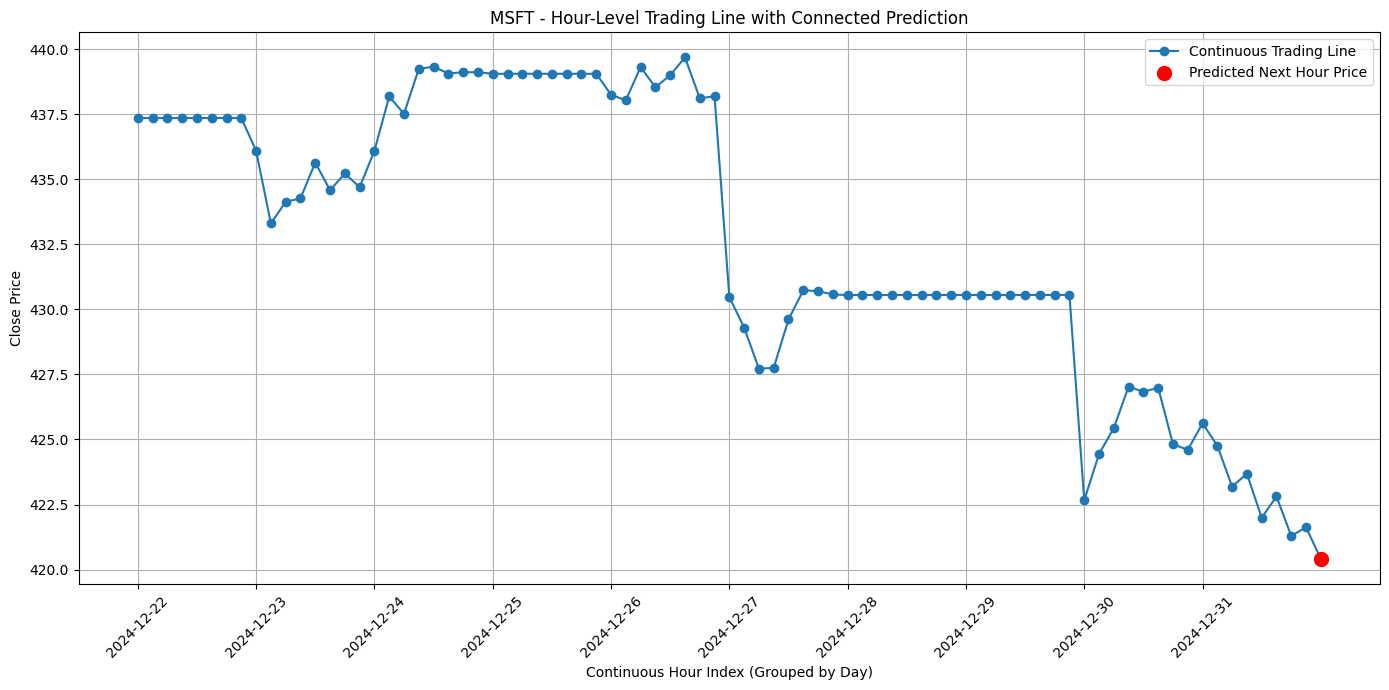

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1249319091.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


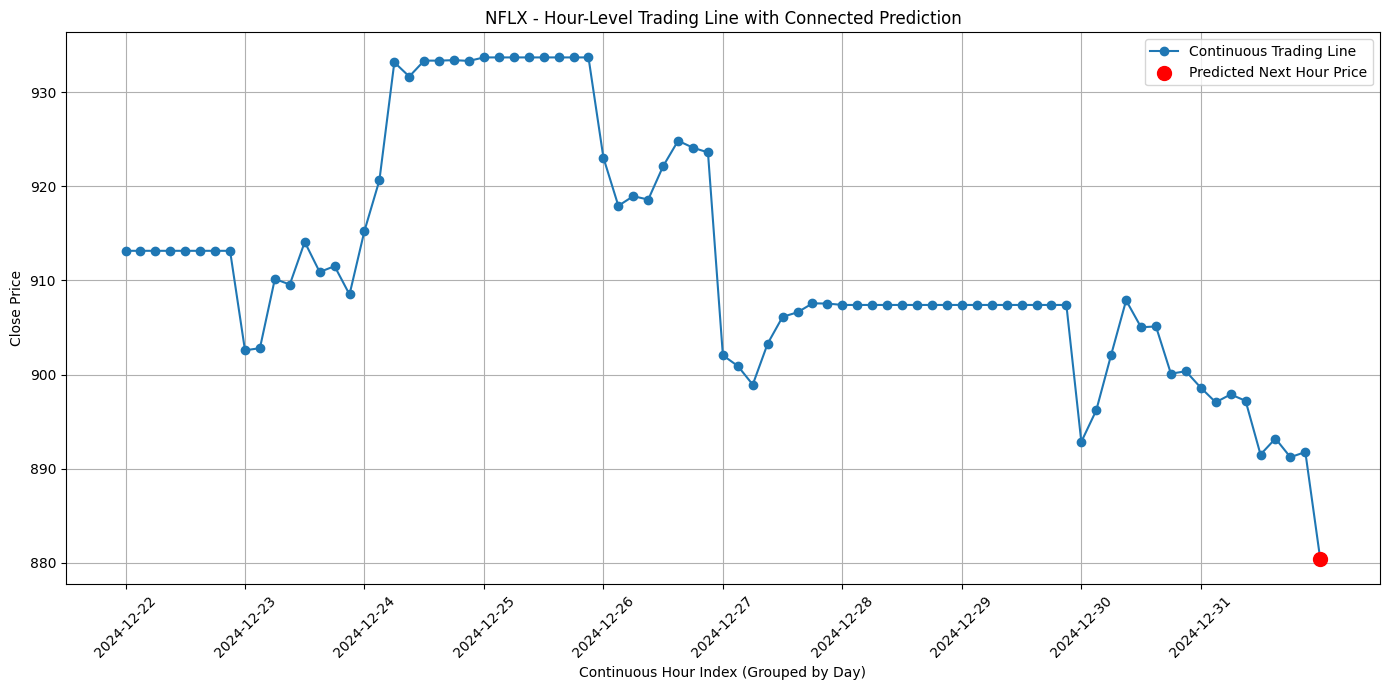

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1249319091.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


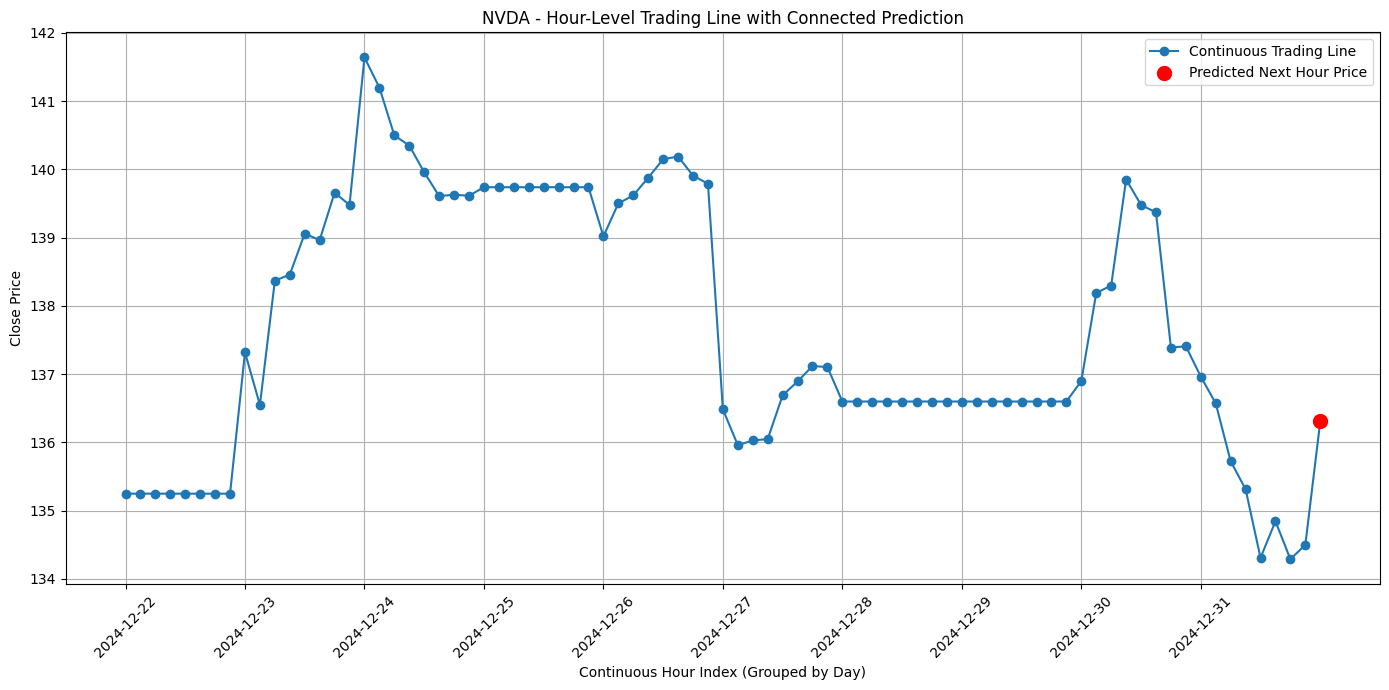

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1249319091.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


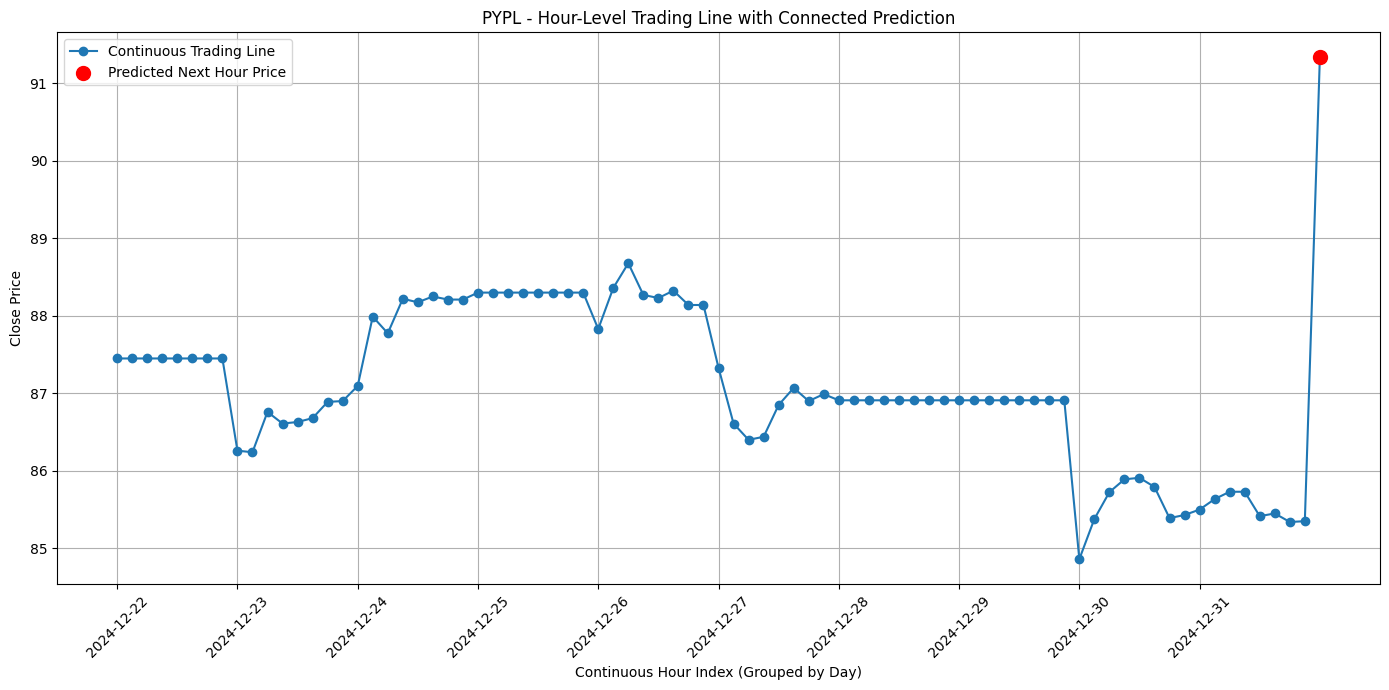

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1249319091.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_10_days = df_symbol.last("10D")


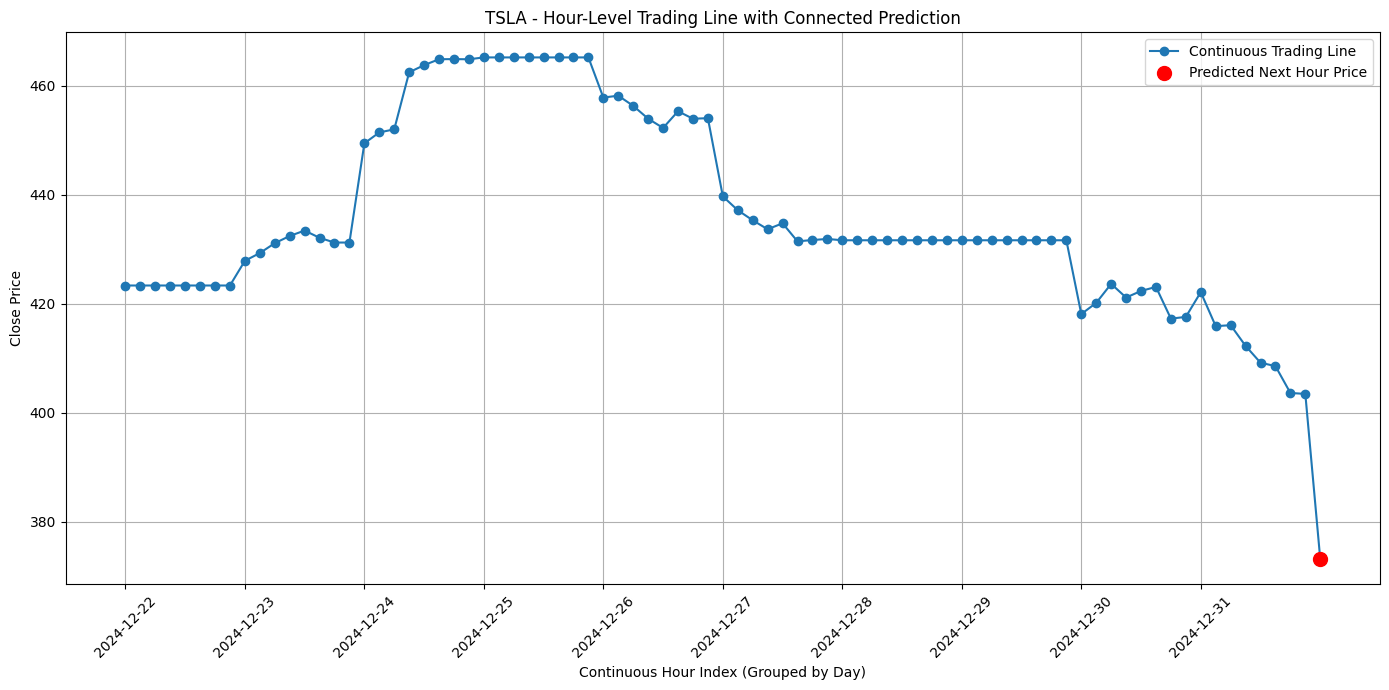

In [28]:
for symbol in symbols_hourly:
    # Get hourly data for the symbol and sort by time.
    df_symbol = hourly_df[hourly_df['symbol'] == symbol].sort_index()
    
    # Use the last 10 days of hourly data.
    last_10_days = df_symbol.last("10D")
    
    # Reset the index to form a continuous series.
    df_cont = last_10_days.copy()
    df_cont['time'] = df_cont.index
    df_cont = df_cont.reset_index(drop=True)
    
    # Create a continuous x-axis.
    x = np.arange(len(df_cont))
    pred_x = len(df_cont)  # Next hour.
    
    # Retrieve the predicted next-hour close price.
    pred_price = predictions_hourly.get(symbol)
    if pred_price is None:
        print(f"Hourly-level: No prediction available for {symbol}.")
        continue

    # Extend the line with the predicted point.
    x_extended = np.append(x, pred_x)
    y_extended = np.append(df_cont['close'].values, pred_price)
    
    plt.figure(figsize=(14, 7))
    plt.plot(x_extended, y_extended, label="Continuous Trading Line", marker='o', linestyle='-')
    plt.scatter([pred_x], [pred_price], color='red', s=100, zorder=5, label="Predicted Next Hour Price")
    
    # Annotate x-axis with day boundaries.
    df_cont['date'] = df_cont['time'].dt.strftime('%Y-%m-%d')
    tick_positions = []
    tick_labels = []
    for date, group in df_cont.groupby('date'):
        tick_positions.append(group.index[0])
        tick_labels.append(date)
    
    plt.xticks(tick_positions, tick_labels, rotation=45)
    plt.xlabel("Continuous Hour Index (Grouped by Day)")
    plt.ylabel("Close Price")
    plt.title(f"{symbol} - Hour-Level Trading Line with Connected Prediction")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Day-level Plots

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1732267557.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_30_days = df_symbol.last("30D")


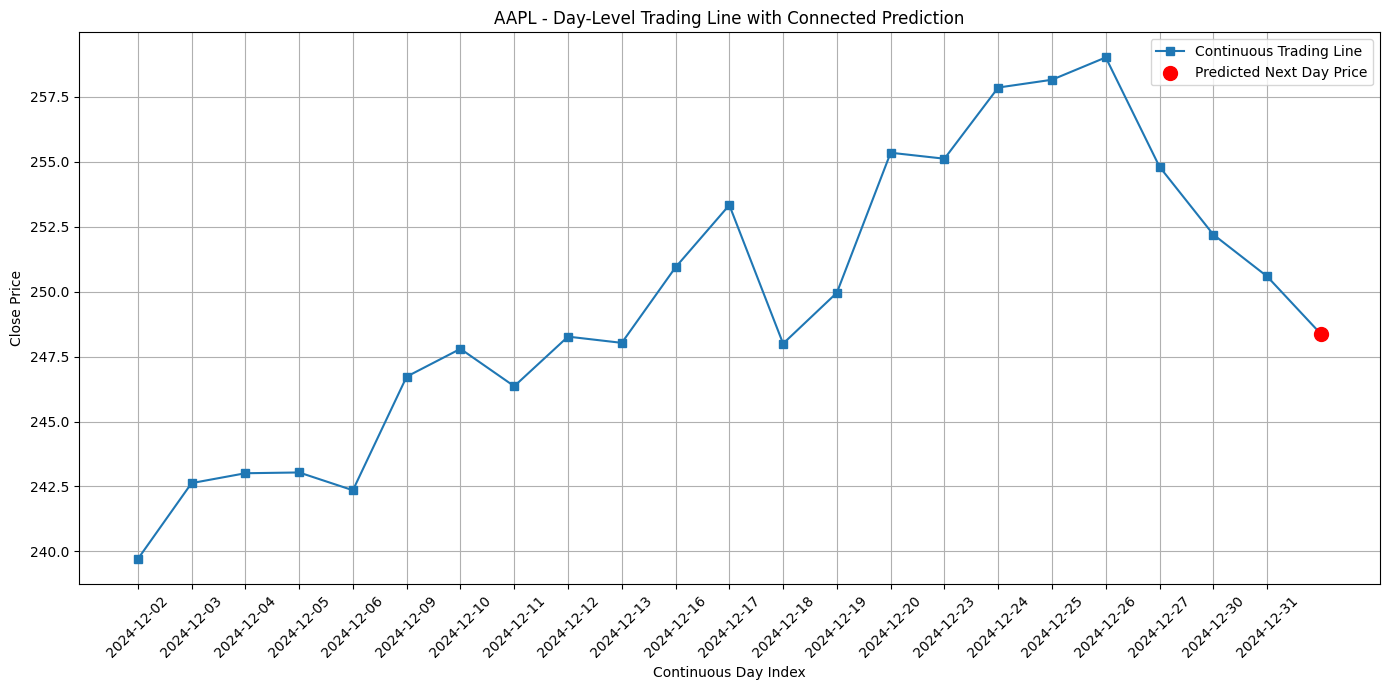

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1732267557.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_30_days = df_symbol.last("30D")


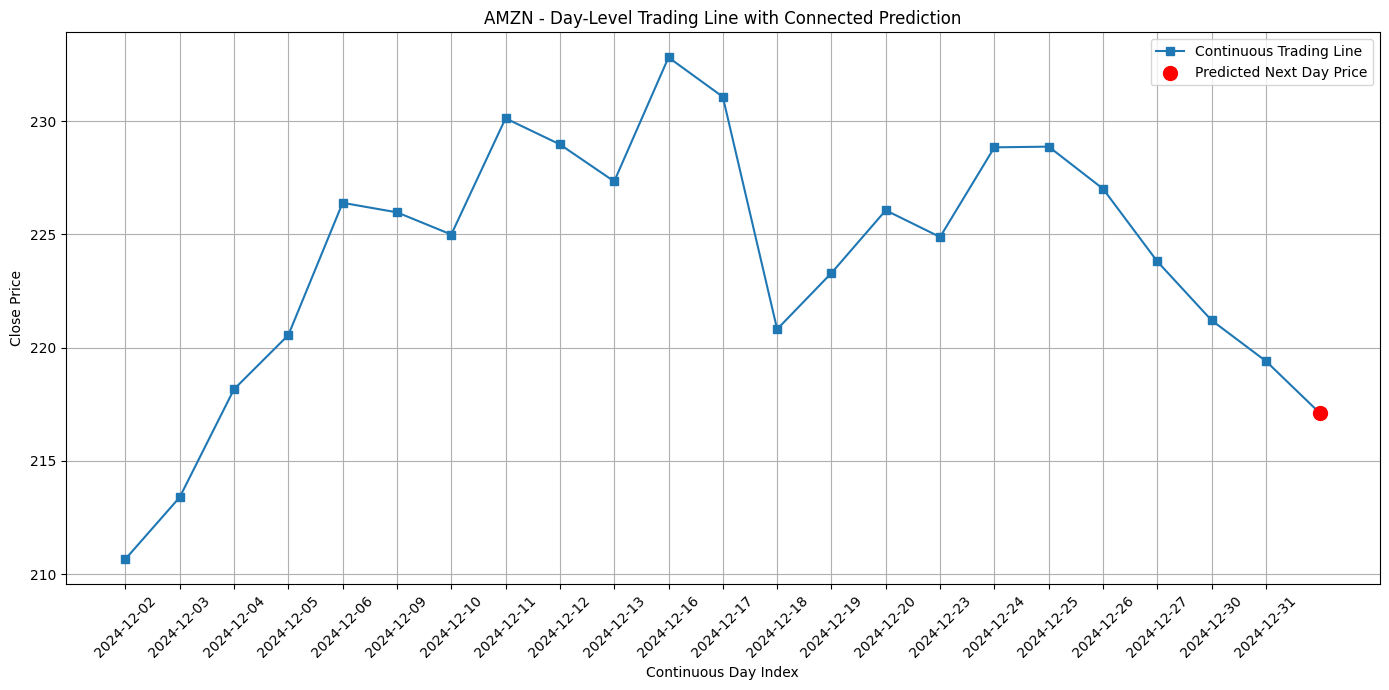

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1732267557.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_30_days = df_symbol.last("30D")


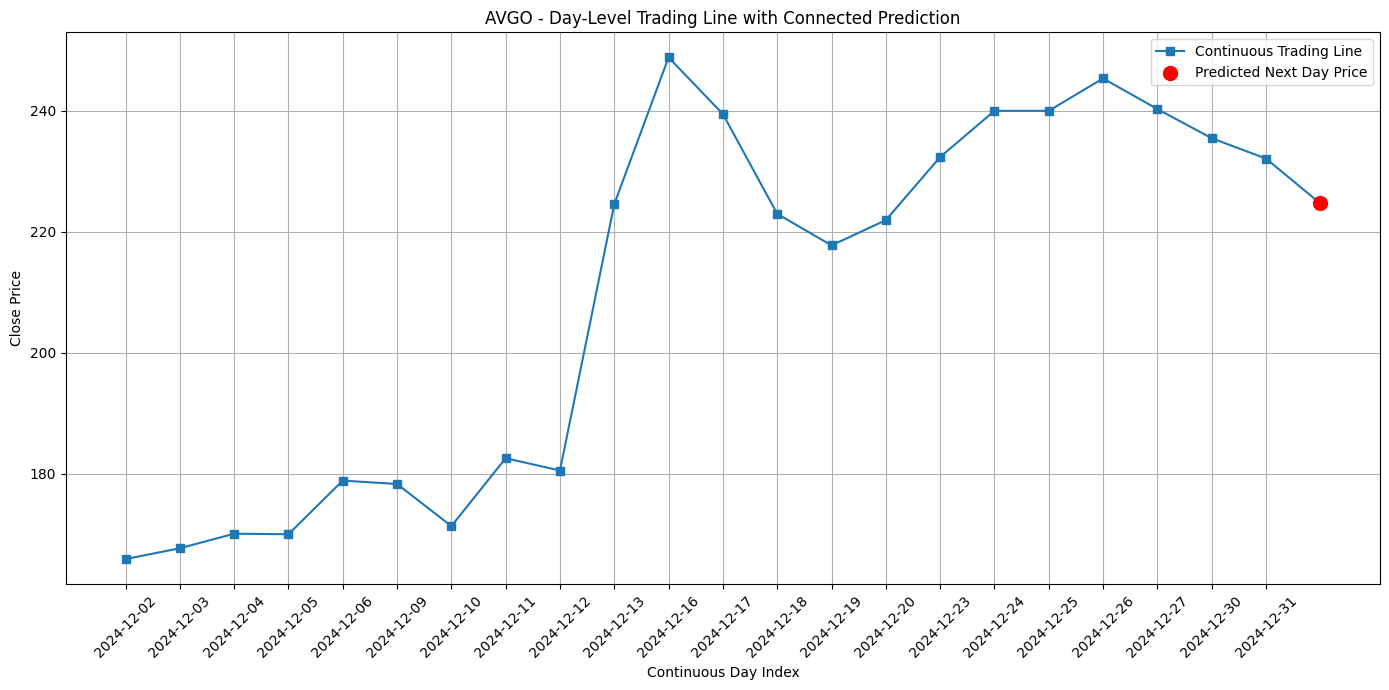

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1732267557.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_30_days = df_symbol.last("30D")


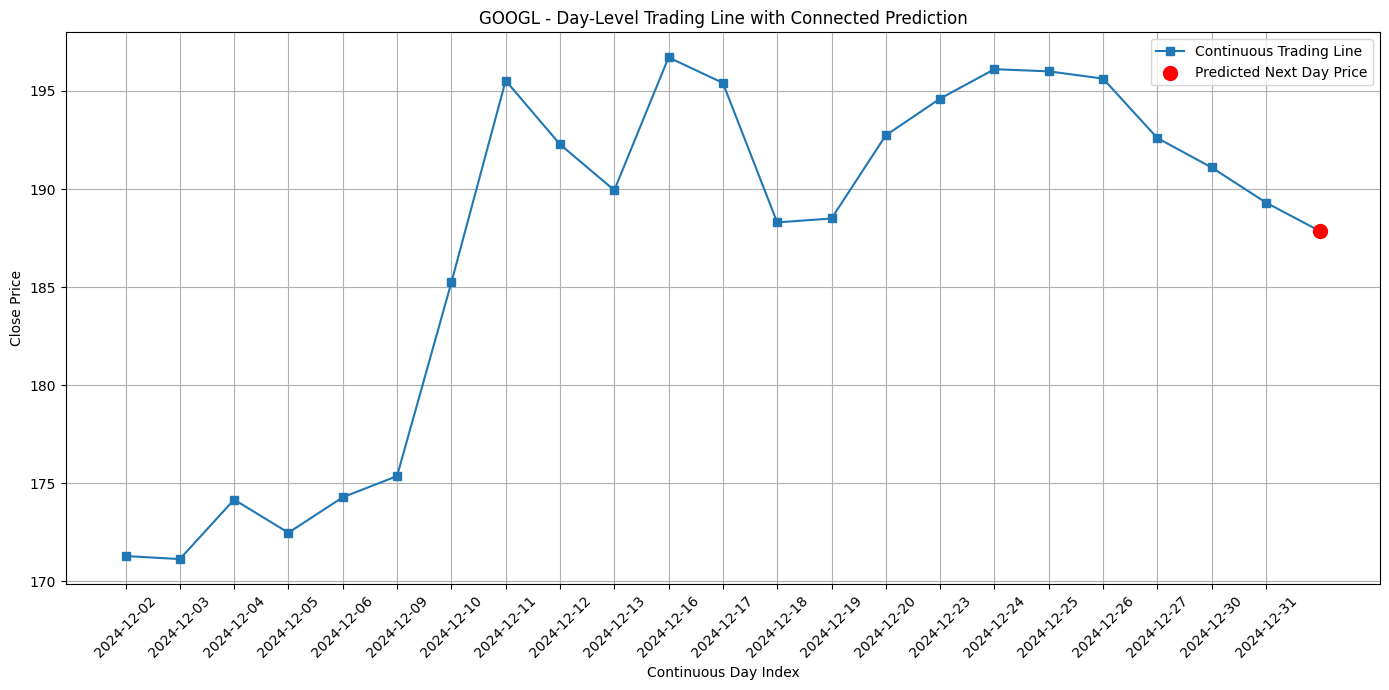

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1732267557.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_30_days = df_symbol.last("30D")


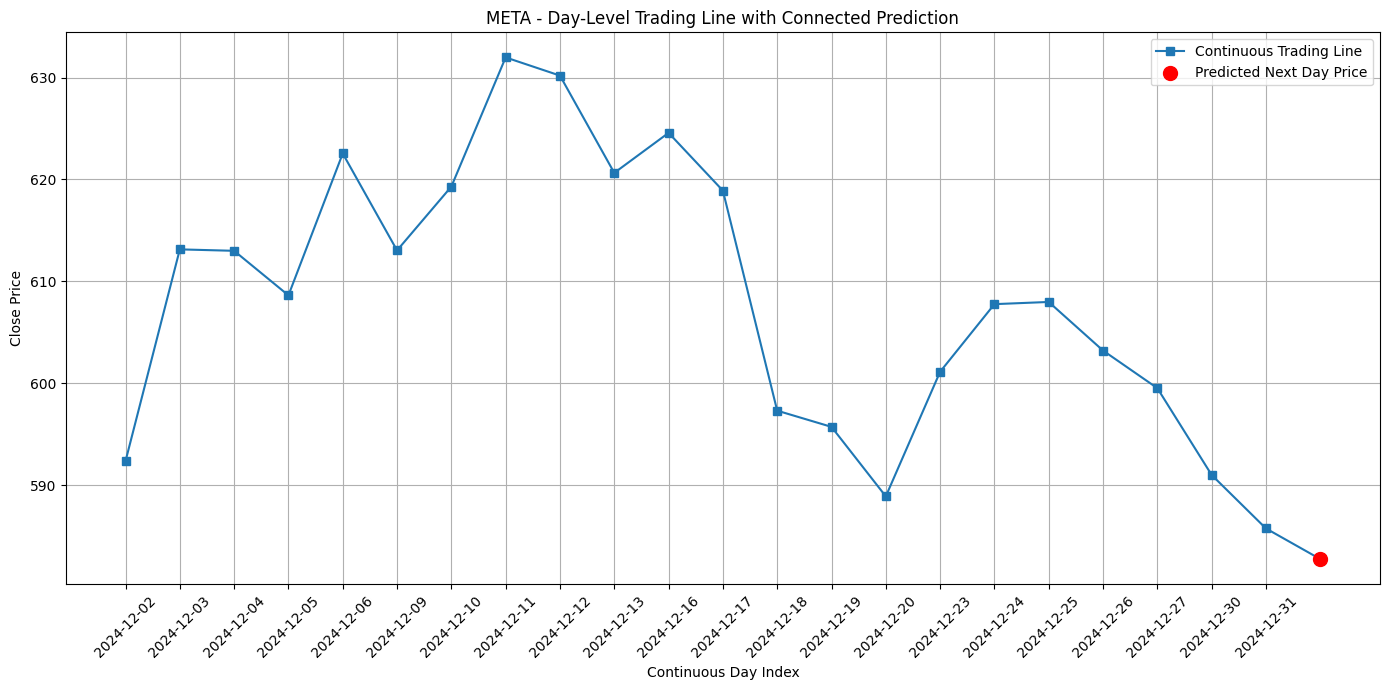

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1732267557.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_30_days = df_symbol.last("30D")


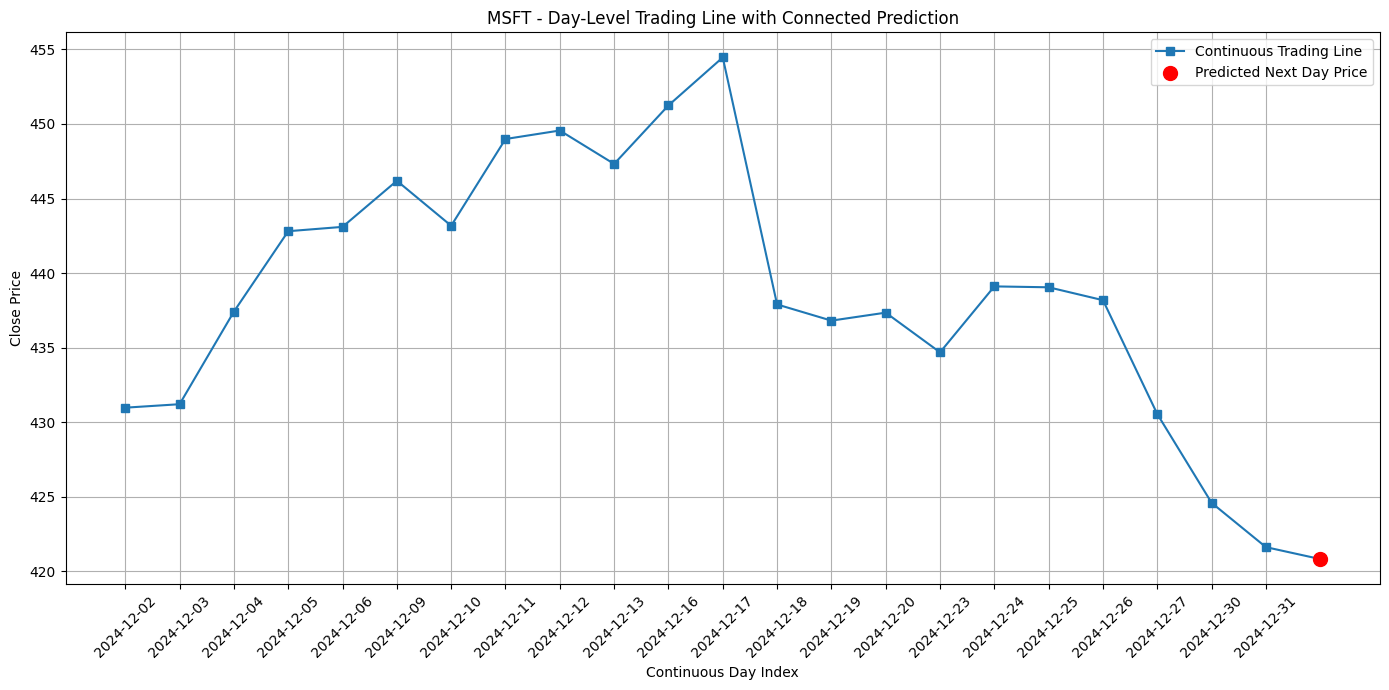

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1732267557.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_30_days = df_symbol.last("30D")


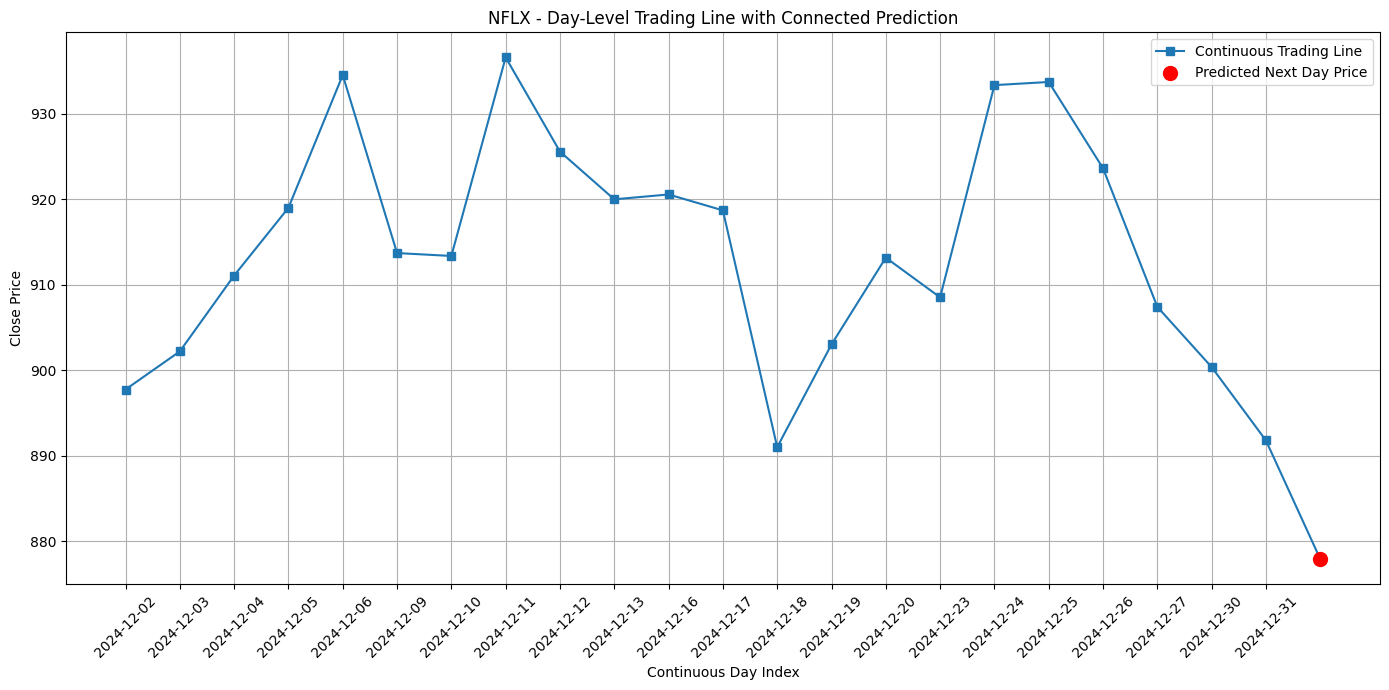

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1732267557.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_30_days = df_symbol.last("30D")


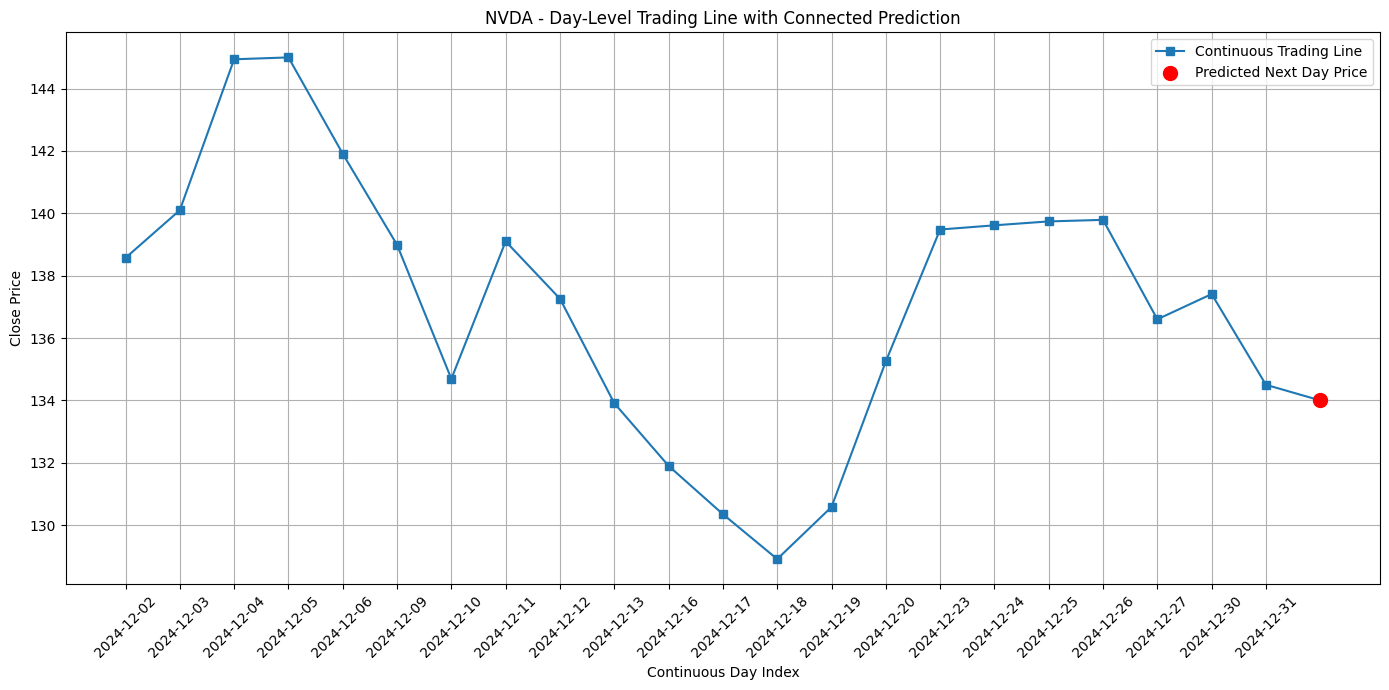

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1732267557.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_30_days = df_symbol.last("30D")


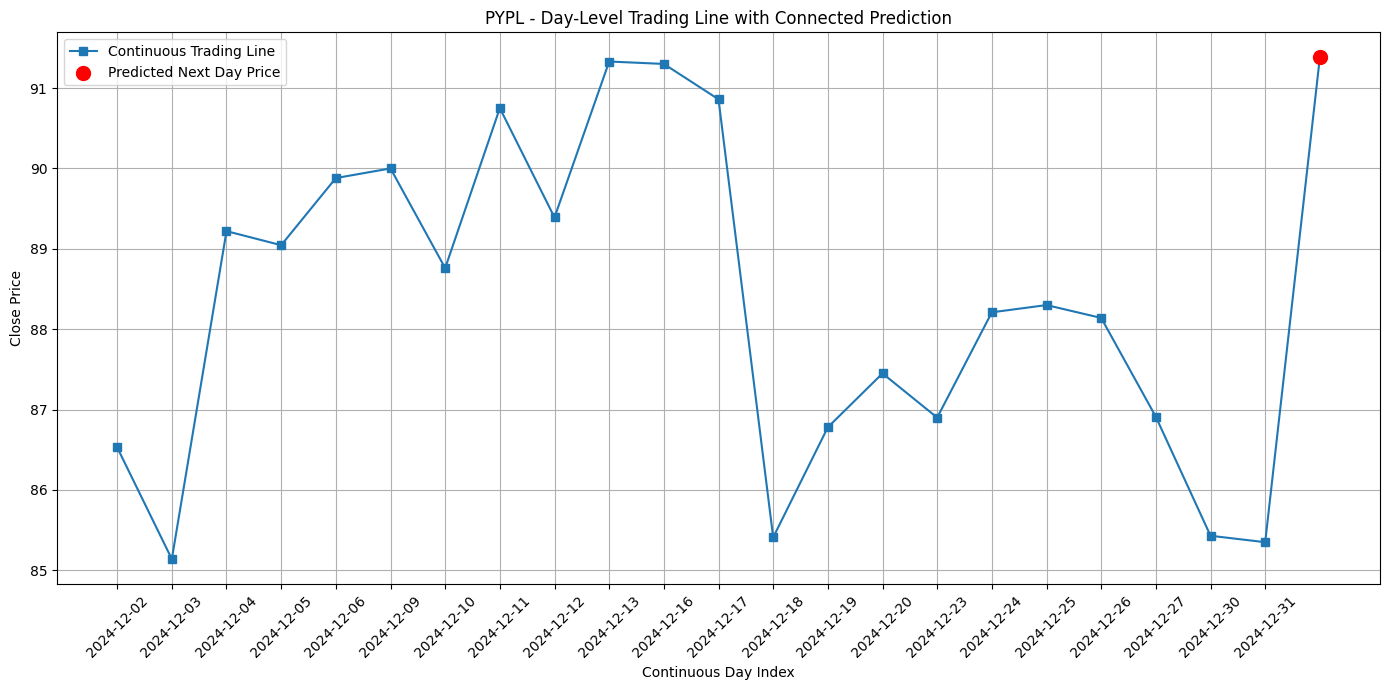

/var/folders/6v/992p8knd6g5flm6m0p856jlw0000gn/T/ipykernel_95782/1732267557.py:6: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_30_days = df_symbol.last("30D")


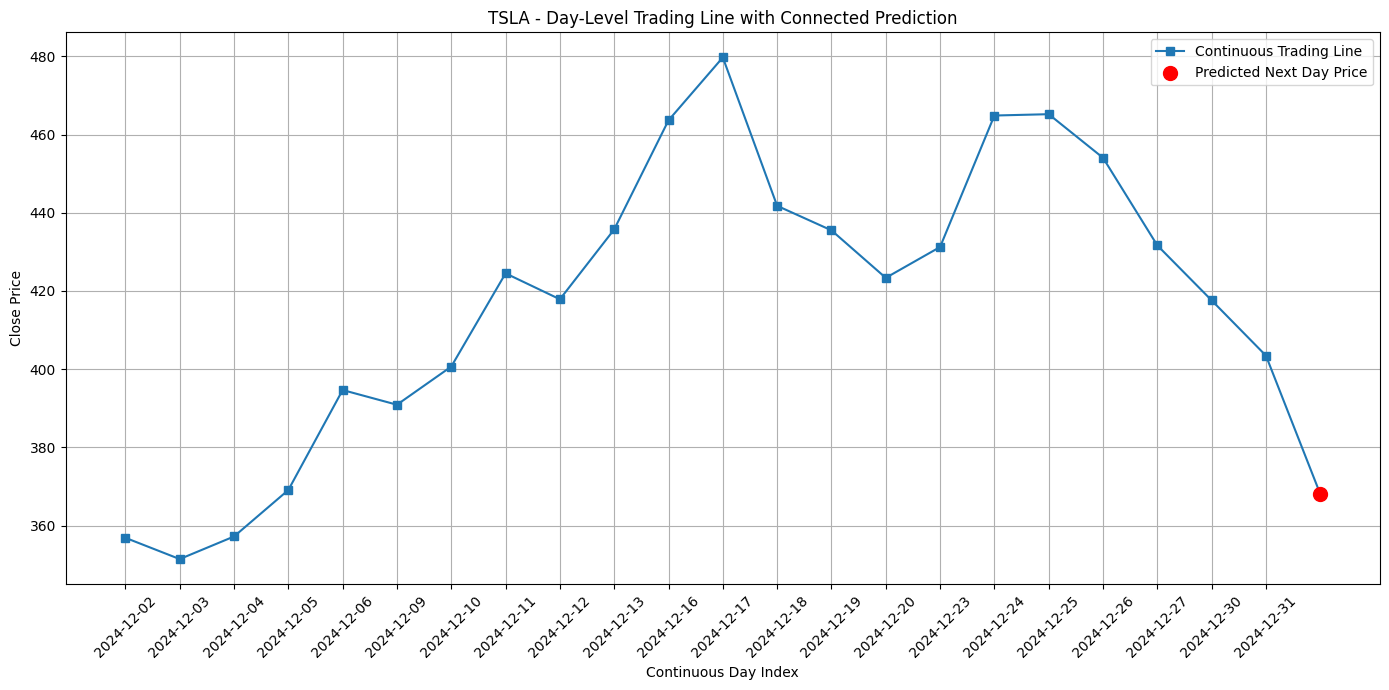

In [31]:
for symbol in symbols_daily:
    # Get the daily data for the symbol and sort by time.
    df_symbol = daily_df[daily_df['symbol'] == symbol].sort_index()
    
    # Use the last 30 days for a clearer view.
    last_30_days = df_symbol.last("30D")
    
    # Reset the index so that days are continuous.
    df_cont = last_30_days.copy()
    df_cont['time'] = df_cont.index
    df_cont = df_cont.reset_index(drop=True)
    
    # Create a continuous x-axis.
    x = np.arange(len(df_cont))
    pred_x = len(df_cont)  # The next day.
    
    # Retrieve the predicted next-day close price.
    pred_price = predictions_daily.get(symbol)
    if pred_price is None:
        print(f"Day-level: No prediction available for {symbol}.")
        continue

    # Extend the historical close series with the prediction.
    x_extended = np.append(x, pred_x)
    y_extended = np.append(df_cont['close'].values, pred_price)
    
    plt.figure(figsize=(14, 7))
    plt.plot(x_extended, y_extended, label="Continuous Trading Line", marker='s', linestyle='-')
    plt.scatter([pred_x], [pred_price], color='red', s=100, zorder=5, label="Predicted Next Day Price")
    
    # Annotate the x-axis with dates.
    df_cont['date'] = df_cont['time'].dt.strftime('%Y-%m-%d')
    tick_positions = list(range(len(df_cont)))
    tick_labels = df_cont['date']
    
    plt.xticks(tick_positions, tick_labels, rotation=45)
    plt.xlabel("Continuous Day Index")
    plt.ylabel("Close Price")
    plt.title(f"{symbol} - Day-Level Trading Line with Connected Prediction")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
